# BAU Validation Trials and Explanation -- RUN these once to test everything Katie! Then delete the API key!

Author: Katherine Shaw 

Date: 16 August 

Purpose of Document: 

BAU validation process from the week of August 11 to August 15, which demonstrated important changes to coal/lignite/gas ratios that need to be made to match to historical data. 

This link demonstrates the in-built validation process for pypsa-eur (terminal code: validate_elec_networks, https://2050plus-climact.readthedocs.io/en/stable/validation.html ), which is only applicable for electric networks. However, this comparison uses data from the 2019 ENTSO-E platform (for which the user will need an API key, process to aquire one described on the Entsoe-E website), and the goal of this test was to compare the first forecaseted year, 2020, in the model to the actual 2020 data. In order to download the right year (2020), the retrieval process was modified and is listed below, with the option to insert your own API key. Using the code below, originally found in the notebook titled "Validation-electricity_production.ipynb" . All the intial tests for the verification can be found in that notebook, and the important and cleaned results from there are listed here. 

Noted issues with the model example given in the documentation for validation electric networks includes: "coal-lignite fuel switch," which describes how the model there has a fuel switch from coal to lignite. "This might result from non-captured subsides for lignite and coal in the model. In order to fix the fual switch from coal to lignite, and manual cost correction is added to the script 'build_monthly_princes.'" 

Other notes issues/posible improvements includes
- overestimation of wind and solar, partiuclar solar dispatch during the winter
- no way to access planned outages of nulcear power plants (also nuclear power plants in some models have changes in their power output that would be infeasible with reality)
- false classification of run-of-river power plants, which are sometimes classifed as hydro and lead to an overproduction from hydro 
- load shedding caused by constrained net transfer capacities (crossborder flows), which leades to high market prices in some regions


Mainly, the takeaway is that the projected use of gas for the electric section is much lower than it should be, which coal and lignite overused in comparison. A carbon price instituted on the model successfully moves energy dispatch away from coal and lignite for the revised mode, but instead of moving to gas the additional energy is generated using wind and solar, leading to a gross overestimation compared to reality in the year 2020. This file ennumerates all the interventions used to try and fix this gas/coal/lignite ration issue, culminating in a forced operational constraint. 

Most of the gas in the model is not being used for power, but instead used for other sectors. The power sector decarbonized quite quickly, so there is an arugument for the projections to 2050 that this will not be a large issue in the end. The counterargument to that is that there must be an assumption or directive somewhere in the model, or lack thereof that is failing to capture the historical switch to gas, accounting for this skewed optimized ratio for 2020, and leaving it in even if dispatch is enforced for 2020 in the power sector will lead to a faulty system buildout in the ensuing decades. 

The goal was to align all the carriers on an (order of magnitude) level 

### Loading packages

In [3]:
#Packages 
import pypsa
import matplotlib.pyplot as plt 
import cartopy 
import geopandas
import networkx
import linopy
import cartopy.crs as ccrs
import atlite 
import geopandas as gpd 
import xarray
import pandas as pd 
from datetime import datetime
import numpy as np
from pypsa.plot import add_legend_patches
import random
import plotly.graph_objects as go

## Overall view of colors matched to carriers 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#importing auxillary functions
import Auxillary_Functions as af

## Loading Historical Weather Data 
From ENTSO-E Transparency Platform

### Loading Electricity Production by type:

In [ ]:
ENTSOE_transparency_platform_api_key = 


In [14]:
# SPDX-FileCopyrightText: Contributors to PyPSA-Eur <https://github.com/pypsa/pypsa-eur>
#
# SPDX-License-Identifier: MIT

import pandas as pd
from entsoe import EntsoePandasClient
from entsoe.exceptions import NoMatchingDataError


carrier_grouper = {
    "Waste": "Biomass",
    "Hydro Pumped Storage": "Hydro",
    "Hydro Water Reservoir": "Hydro",
    "Hydro Run-of-river and poundage": "Run of River",
    "Fossil Coal-derived gas": "Gas",
    "Fossil Gas": "Gas",
    "Fossil Oil": "Oil",
    "Fossil Oil shale": "Oil",
    "Fossil Brown coal/Lignite": "Lignite",
    "Fossil Peat": "Lignite",
    "Fossil Hard coal": "Coal",
    "Wind Onshore": "Onshore Wind",
    "Wind Offshore": "Offshore Wind",
    "Other renewable": "Other",
    "Marine": "Other",
}

api_key = ENTSOE_transparency_platform_api_key
client = EntsoePandasClient(api_key=api_key)

start = pd.Timestamp("2019-01-01", tz="Europe/Brussels")
end = pd.Timestamp("2020-01-01", tz="Europe/Brussels")

countries = ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'XK']


generation = []
unavailable_countries = []

for country in countries:
    country_code = country

    try:
        gen = client.query_generation(country, start=start, end=end, nett=True)
        gen = gen.tz_localize(None).resample("1h").mean() #resampled for every hour? 
        gen = gen.loc[start.tz_localize(None) : end.tz_localize(None)]
        gen = gen.rename(columns=carrier_grouper).T.groupby(level=0).sum().T
        generation.append(gen)
    except NoMatchingDataError:
        unavailable_countries.append(country)

if unavailable_countries:
    print(
        f"Historical electricity production for countries {', '.join(unavailable_countries)} not available."
    )

keys = [c for c in countries if c not in unavailable_countries]
generation = pd.concat(generation, keys=keys, axis=1)
#generation.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/Entsoe_electricity_production.csv')

Historical electricity production for countries AL, XK not available.


The only countries in the model that are not included in the ENTSOE-E data is ALbania and Kosovo 

### Loading Cross Border Flows 

In [ ]:
network_choice = #insert here the network so that the retrieval code below captures the correct cross border flows

In [34]:
# SPDX-FileCopyrightText: Contributors to PyPSA-Eur <https://github.com/pypsa/pypsa-eur>
#
# SPDX-License-Identifier: MIT


import pandas as pd
import pypsa
from entsoe import EntsoePandasClient
from entsoe.exceptions import InvalidBusinessParameterError, NoMatchingDataError
from requests import HTTPError

client = EntsoePandasClient(api_key=api_key)


n = network_choice
start = pd.Timestamp("2019-01-01", tz="Europe/Brussels")
end = pd.Timestamp("2020-01-01", tz="Europe/Brussels")

branches = n.branches().query("carrier in ['AC', 'DC']")
c = n.buses.country
branch_countries = pd.concat([branches.bus0.map(c), branches.bus1.map(c)], axis=1)
branch_countries = branch_countries.query("bus0 != bus1")
branch_countries = branch_countries.apply(sorted, axis=1, result_type="broadcast")
country_pairs = branch_countries.drop_duplicates().reset_index(drop=True)

flows = []
unavailable_borders = []
for from_country, to_country in country_pairs.values:
    try:
        flow_directed = client.query_crossborder_flows(
            from_country, to_country, start=start, end=end
        )
        flow_reverse = client.query_crossborder_flows(
            to_country, from_country, start=start, end=end
        )
        flow = (flow_directed - flow_reverse).rename(
            f"{from_country} - {to_country}"
        )
        flow = flow.tz_localize(None).resample("1h").mean()
        flow = flow.loc[start.tz_localize(None) : end.tz_localize(None)]
        flows.append(flow)
    except (HTTPError, NoMatchingDataError, InvalidBusinessParameterError):
        unavailable_borders.append(f"{from_country}-{to_country}")

if unavailable_borders:
    print(
        "Historical electricity cross-border flows for countries"
        f" {', '.join(unavailable_borders)} not available."
    )

flows = pd.concat(flows, axis=1)
flows.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/cross_border_flows.csv')


NameError: name 'network_choice' is not defined

### Loading day-Ahead Prices 

In [ ]:
# SPDX-FileCopyrightText: Contributors to PyPSA-Eur <https://github.com/pypsa/pypsa-eur>
#
# SPDX-License-Identifier: MIT

import logging

import pandas as pd
from entsoe import EntsoePandasClient
from entsoe.exceptions import NoMatchingDataError

client = EntsoePandasClient(api_key=api_key)


start = pd.Timestamp("2019-01-01", tz="Europe/Brussels")
end = pd.Timestamp("2020-01-01", tz="Europe/Brussels")

countries = ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'XK']


prices = []
unavailable_countries = []

for country in countries:
    country_code = country

    try:
        gen = client.query_day_ahead_prices(country, start=start, end=end)
        gen = gen.tz_localize(None).resample("1h").mean()
        gen = gen.loc[start.tz_localize(None) : end.tz_localize(None)]
        prices.append(gen)
    except NoMatchingDataError:
        unavailable_countries.append(country)

if unavailable_countries:
    print(
        f"Historical electricity prices for countries {', '.join(unavailable_countries)} not available."
    )

keys = [c for c in countries if c not in unavailable_countries]
prices = pd.concat(prices, keys=keys, axis=1)


I already have the ENTSOE-E records downloaded, so I am going to load the entsoe-production and cross border flows below 


In [14]:
historic_entsoe_2020 = pd.read_csv(
    '/Users/katherine.shaw/Desktop/pypsa-eur/2020 entsoe-e/historical_electricity_production.csv',
    index_col=0,
    header=[0, 1],
    parse_dates=True,
)

subset_technologies = ["Geothermal", "Nuclear", "Biomass", "Lignite", "Oil", "Coal"]
lowercase_technologies = [
    technology.lower() if technology in subset_technologies else technology
    for technology in historic_entsoe_2020.columns.levels[1]
    ]
historic_entsoe_2020.columns = historic_entsoe_2020.columns.set_levels(lowercase_technologies, level=1)

In [ ]:
historic_entsoe_2020

AT                                            \
                    biomass    coal      Gas geothermal    Hydro  oil   
2019-01-01 00:00:00   404.0  155.75  1282.75        0.0 -1497.00  0.0   
2019-01-01 01:00:00   404.0  155.00   945.75        0.0 -1441.00  0.0   
2019-01-01 02:00:00   404.0  155.50   618.75        0.0 -1361.50  0.0   
2019-01-01 03:00:00   404.0  155.75   575.50        0.0 -1586.50  0.0   
2019-01-01 04:00:00   404.0  154.25   449.50        0.0 -1524.00  0.0   
...                     ...     ...      ...        ...      ...  ...   
2019-12-31 20:00:00   320.0  162.00  1820.50        0.0  1006.75  0.0   
2019-12-31 21:00:00   320.0  163.25  1785.00        0.0   540.25  0.0   
2019-12-31 22:00:00   318.0  153.75  1723.00        0.0   301.00  0.0   
2019-12-31 23:00:00   317.0  144.75  1664.50        0.0   329.00  0.0   
2020-01-01 00:00:00     NaN     NaN      NaN        NaN      NaN  NaN   

                                                           ...    SK         \
                    Onshore Wind Other Run of River Solar  ...  coal    Gas   
2019-01-01 00:00:00        248.0  22.0      2680.00   0.0  ...  59.0  182.0   
2019-01-01 01:00:00        189.0  22.0      2703.50   0.0  ...  60.0  176.0   
2019-01-01 02:00:00        142.0  22.0      2734.75   0.0  ...  61.0  180.0   
2019-01-01 03:00:00        118.0  22.0      2746.50   0.0  ...  57.0  172.0   
2019-01-01 04:00:00        165.0  22.0      2703.50   0.0  ...  58.0  173.0   
...                          ...   ...          ...   ...  ...   ...    ...   
2019-12-31 20:00:00       1800.0  22.0      2417.75   0.0  ...   0.0  220.0   
2019-12-31 21:00:00       1957.0  22.0      2376.50   0.0  ...   0.0  200.0   
2019-12-31 22:00:00       2028.0  22.0      2325.75   0.0  ...   0.0  201.0   
2019-12-31 23:00:00       1944.0  22.0      2175.00   0.0  ...   0.0  201.0   
2020-01-01 00:00:00          NaN   NaN          NaN   NaN  ...   NaN    NaN   

                                                                      \
                     Hydro lignite nuclear   oil Onshore Wind  Other   
2019-01-01 00:00:00   -1.0   186.0  1928.0  44.0          0.0  278.0   
2019-01-01 01:00:00  -11.0   112.0  1928.0  44.0          0.0  292.0   
2019-01-01 02:00:00   17.0   109.0  1927.0  45.0          0.0  295.0   
2019-01-01 03:00:00  -92.0   107.0  1929.0  46.0          0.0  288.0   
2019-01-01 04:00:00 -111.0   108.0  1929.0  47.0          0.0  293.0   
...                    ...     ...     ...   ...          ...    ...   
2019-12-31 20:00:00  181.0   187.0  1940.0  49.0          1.0  223.0   
2019-12-31 21:00:00   63.0   186.0  1943.0  50.0          1.0  219.0   
2019-12-31 22:00:00    3.0   182.0  1942.0  50.0          1.0  220.0   
2019-12-31 23:00:00   11.0   178.0  1943.0  48.0          1.0  219.0   
2020-01-01 00:00:00    NaN     NaN     NaN   NaN          NaN    NaN   

                                        
                    Run of River Solar  
2019-01-01 00:00:00        295.0   0.0  
2019-01-01 01:00:00        267.0   0.0  
2019-01-01 02:00:00        279.0   0.0  
2019-01-01 03:00:00        275.0   0.0  
2019-01-01 04:00:00        266.0   0.0  
...                          ...   ...  
2019-12-31 20:00:00        532.0   1.0  
2019-12-31 21:00:00        522.0   1.0  
2019-12-31 22:00:00        461.0   1.0  
2019-12-31 23:00:00        367.0   1.0  
2020-01-01 00:00:00          NaN   NaN  

[8761 rows x 262 columns]

## Auxillary Functions 

In [5]:
def bus_connections(network, bus_name): 
    if bus_name in network.buses.index.values:

        connected_generators = network.generators[network.generators.bus == bus_name]
        connected_loads = network.loads[network.loads.bus == bus_name]
        connected_storage_units = network.storage_units[network.storage_units.bus == bus_name]
        connected_links_in = network.links[network.links.bus1 == bus_name]
        connected_links_out = network.links[network.links.bus0 == bus_name]
        connected_lines = network.lines[(network.lines.bus0 == bus_name) | (network.lines.bus1 == bus_name)]
        connected_transformers = network.transformers[(network.transformers.bus0 == bus_name) | (network.transformers.bus1 == bus_name)]
        connected_stores = network.stores[network.stores.bus == bus_name]
        if any(connected_generators.index.values):
            print("The generators connected to this bus are:    " + str(connected_generators.index.values))
        if any(connected_loads.index.values):
            print("The loads connected to this bus are:     " + str(connected_loads.index.values))
        if any(connected_storage_units.index.values):
            print("The storage units connected to this bus are:   " + str(connected_storage_units.index.values))
        if any(connected_stores.index.values):
            print("The stores connected to this bus are:   " + str(connected_stores.index.values))
        if any(connected_links_in.index.values):
            print("The incoming links to this bus are from the bus:  " +  str(connected_links_in.bus0.values))
        if any(connected_links_in.index.values):
            print("The incoming links are:  " +  str(connected_links_in.index))
        if any(connected_links_out.index.values):
            print("The outgoing links from this bus are to the bus:  " +  str(connected_links_out.bus1.values))
        if any(connected_lines.index.values):
            print("The lines connected to this bus are connected to:   "  + str(connected_lines.bus1.values))
        if any(connected_transformers.index.values):
            print(connected_transformers.index.values)
        return None    
    else:      
        return str("This bus does not exist in the network")
    


def combine_series_by_dictionary(series1: pd.Series, series2: pd.Series, matched_data_dictionary: dict) -> pd.DataFrame:
    """
    Combines two pandas Series into a single DataFrame based on a dictionary
    that maps multiple source indices to a single target index.
    Values for matched source indices are summed under the target index.
    Rows in the series that do not match any dictionary values are ignored.

    Args:
        series1 (pd.Series): The first pandas Series.
        series2 (pd.Series): The second pandas Series.
        matched_data_dictionary (dict): A dictionary where keys are the
                                        desired new DataFrame indices, and
                                        values are lists of original indices
                                        to be mapped to that new index.

    Returns:
        pd.DataFrame: A DataFrame with the aggregated values under the new indices.
    """
    
    # Initialize a dictionary to store the aggregated data
    combined_data = {}

    # Iterate through the target indices and their corresponding source indices
    for target_index, source_indices_list in matched_data_dictionary.items():
        total_value_series1 = 0
        total_value_series2 = 0
        
        # Aggregate values for series1
        for source_index in source_indices_list:
            if source_index in series1.index:
                total_value_series1 += series1.loc[source_index]
        
        # Aggregate values for series2
        for source_index in source_indices_list:
            if source_index in series2.index:
                total_value_series2 += series2.loc[source_index]
        
        # Store the aggregated values for this target_index
        combined_data[target_index] = {
            'Series1_Value': total_value_series1,
            'Series2_Value': total_value_series2
        }
    
    # Create a DataFrame from the combined data
    # Orienting from_dict to 'index' makes the dictionary keys the DataFrame index
    df = pd.DataFrame.from_dict(combined_data, orient='index')
    
    # Ensure columns are properly named
    df.columns = ['Historic', 'Optimized']
    
    return df


#To graph the result:
'''
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="y")
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()
''' 



def electric_supply_from_the_sector_models(network_choice):
    #gets the total supply from the various carriers to the electric sector of the model, where applicable 
    ##the renewable generators connect directly to the AC buses 
    ## the conventional links deliver a certain amount of energy to the AC buses -- in the sector models the big loads are connected to the low voltage buses
  network = network_choice
  supply = {}

    #renewables 
  renewable_carriers = ['solar', 'offwind-dc', 'onwind',
       'offwind-ac', 'offwind-float', 'solar-hsat', 'ror', 'solar rooftop', 'hydro', 'ror', 'PHS']
      #generators 
  renewable_generators_by_carrier = network.generators[network.generators.carrier.isin(renewable_carriers)].index
  renewable_generators_by_carrier 
  renewables_dispatch = network.generators_t.p[renewable_generators_by_carrier]
  renewables_dispatch = renewables_dispatch.T
  renewables_dispatch=renewables_dispatch.groupby(network.generators.carrier).sum()
  renewables_dispatch = renewables_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh 
  renewables_dispatch = renewables_dispatch.sum(axis=1)
    #low carbon carriers
  low_carbon_carriers = ['nuclear', 'geothermal']
  low_carbon_carriers = network.generators[network.generators.carrier.isin(low_carbon_carriers)].index
  low_carbon_dispatch = network.generators_t.p[low_carbon_carriers]
  low_carbon_dispatch = low_carbon_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh
  low_carbon_dispatch = low_carbon_dispatch.T
  low_carbon_dispatch = low_carbon_dispatch.groupby(network.generators.carrier).sum()
  low_carbon_dispatch = low_carbon_dispatch.sum(axis=1)
  low_carbon_dispatch
    #conventional carriers = 
  conventional_carriers = ['coal', 'lignite', 'CCGT', 'OCGT', 'oil', "urban central solid biomass CHP", "urban central CHP", "urban central solid biomass CHP CC", "urban central CHP CC"] #biomass is technically low carbon, but CHP is given in links. biomass CHP only in urban central
  conventional_links = network.links[network.links.carrier.isin(conventional_carriers)].index
  conventional_links = network.links_t.p1[conventional_links]#power delivered to the end bus 
  conventional_links = conventional_links * network.snapshot_weightings.objective[0] * -1 #MW --> MWh, and multiplied by netgative one because contributing power to those buses
  conventional_links = conventional_links.T
  conventional_links = conventional_links.groupby(network.links.carrier).sum()
  conventional_links = conventional_links.sum(axis=1)
  conventional_links


  #hydro
  hydro_dispatch = network.storage_units_t.p_dispatch.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
  hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh



  dispatch_dict = {k: v for s in [renewables_dispatch, low_carbon_dispatch, conventional_links, hydro_dispatch] for k, v in s.items()}
  return dispatch_dict 

## The BASE Scenario
The BAU scenario with no modifications yes to change any of the conventional carrier ratios

In [ ]:
#Loading the scenario 
### This is from my computer, but the configuration file will be available in the pypsa github to access and run locally, 
# This configuration is built off config.Europe_scenarios_second_run.yaml, and the tests were run using a duplicate of this file titled config.BAU_validation_test_config.yaml 

#filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/BAU validation/BAU_base/networks/base_s_39___2020.nc'

#insert correct filepath below

filepath2 = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc'
base_2020 = pypsa.Network(filepath2)

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
matched_data_dictionary2 = {
    'Onshore Wind': ['Onshore Wind', 'onwind', 'onshore wind'],
    'Offshore Wind': ['Offshore Wind', 'Offshore Wind (AC)', 'Offshore Wind (DC)', 'Offshore Wind (Floating)', 'offwind-ac', 'offwind-dc', 'offwind-float', 'offshore wind'],
    'Solar' : ['Solar', 'solar-hsat', 'solar', 'solar rooftop'],
    'Nuclear': ['Nuclear', 'nuclear'], 
    'Run of River': ['Run of River', 'ror'],
    'Hydro': ['Hydro', 'hydro', 'PHS', 'Pumped Hydro Storage', 'Reservoir & Dam'],
    'Coal': ['Coal', 'coal'], 
    'Lignite': ['Lignite', 'lignite'],
    'Gas': ['Gas', 'gas', 'Combined-Cycle Gas', 'Open-Cycle Gas', 'CCGT', 'OCGT',  "urban central CHP", "urban central CHP CC"],
    'Geothermal': ['Geothermal', 'geothermal'],
    'Biomass': ['Biomass', 'solid biomass', 'urban central solid biomass CHP', 'urban central solid biomass CHP CC', 'biomass'],
    'Other': ['Other'],
    'Oil': ['oil', 'Oil']
    }

In [ ]:
#Supply from the historic dataset from entsoe-E in 2020
historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1) 

Gas              5.783204e+08
Hydro            2.749564e+08
Offshore Wind    5.820952e+07
Onshore Wind     3.420156e+08
Other            8.299940e+07
Run of River     1.942309e+08
Solar            1.141698e+08
biomass          1.115539e+08
coal             2.040682e+08
geothermal       5.943592e+06
lignite          2.596650e+08
nuclear          8.082461e+08
oil              1.742395e+07
dtype: float64

The graph below shows the ***sector*** supply using base_2020.statitstics().loc['Generator']['Supply'], which includes gas provided by the virgin gas generators and such via the statistics module. 

In [ ]:
df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), base_2020.statistics().loc['Generator']['Supply'], matched_data_dictionary2 )

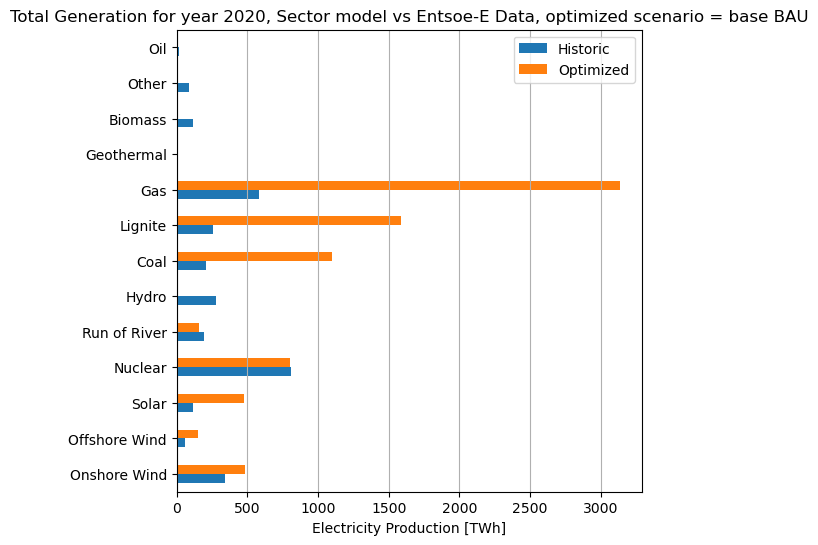

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.title('Total Generation for year 2020, Sector model vs Entsoe-E Data, optimized scenario = base BAU')
plt.show()

The following graph was made using the sector model, but one in which the power generated by components is only counted if it is then transfered to electric buses is found below. 

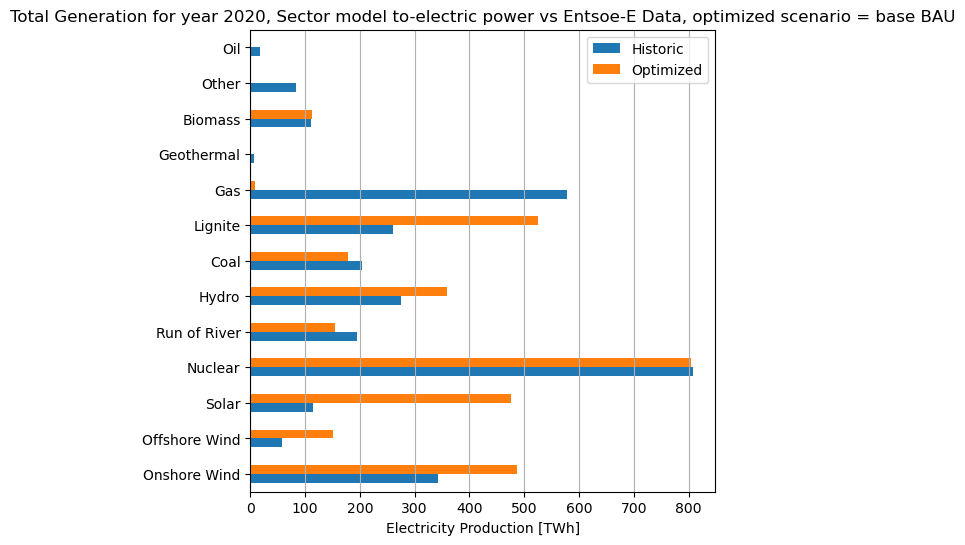

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(base_2020)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector model to-electric power vs Entsoe-E Data, optimized scenario = base BAU')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()                                



As you can see here, gas is wildly under-represented. with lignite producing far above what would have been expected for the 2020 system. The original validate_elec_networks process was done using a network solved only with power system considerations (rule: solve_elec_networks), so this was replicated below using the same configuration file to assess if gas cwas calaculated in that mannyer to be more represented: 

In [ ]:
base_2020_electric_only_solve = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39_elec_.nc')
base_2020_electric_only_solve.statistics()['Supply'].droplevel(0)

INFO:pypsa.io:Imported network base_s_39_elec_.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Combined-Cycle Gas          3.060906e+07
Offshore Wind (AC)          5.181016e+01
Offshore Wind (DC)          4.525762e+01
Offshore Wind (Floating)    3.924408e+01
Onshore Wind                3.108058e+08
Open-Cycle Gas              2.293320e+00
Run of River                1.543773e+08
Solar                       2.241455e+02
biomass                     1.026802e+08
coal                        5.678178e+08
geothermal                  8.584315e+05
lignite                     5.292454e+08
nuclear                     8.015903e+08
oil                         4.413090e+00
solar-hsat                  3.959924e+08
AC                          8.493267e+08
DC                          2.890192e+08
H2 electrolysis             5.067864e+01
H2 fuel cell                2.534996e+01
battery charger             1.039017e+03
battery discharger          1.018026e+03
-                           0.000000e+00
Battery Storage             1.034959e+02
Pumped Hydro Storage        4.534696e+07
Reservoir & Dam 

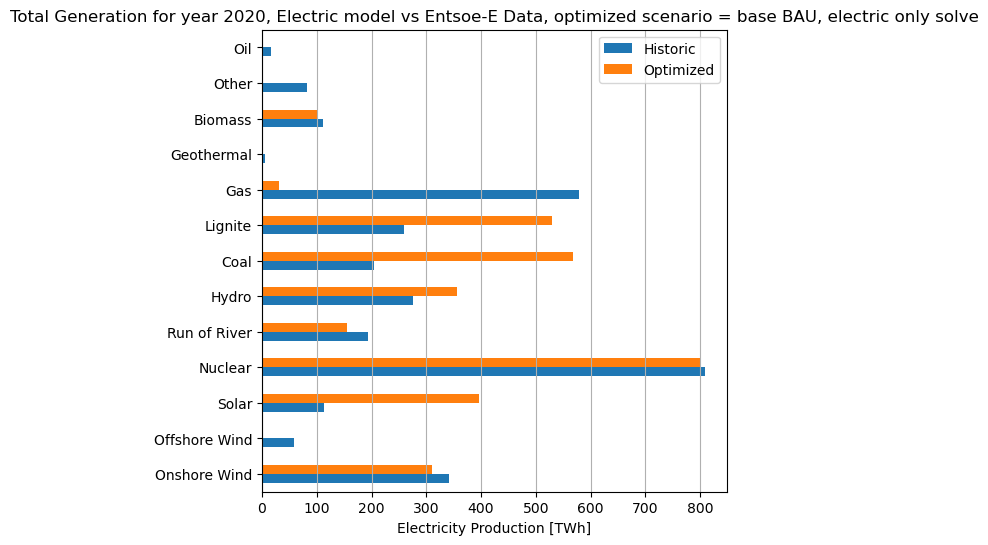

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), base_2020_electric_only_solve.statistics()['Supply'].droplevel(0), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel = "")
ax.grid(axis = "x")
plt.title('Total Generation for year 2020, Electric model vs Entsoe-E Data, optimized scenario = base BAU, electric only solve')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()   

There was more gas used in this model bus, however coal also overpassed lignite as the dominant conventional carrier. 

In [ ]:
print(f'The amount of TWh produced and recorded in Entsoe-E in 2020: {historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1).sum():.2e}')

The amount of TWh produced and recorded in Entsoe-E in 2020: 3.05e+09


In [ ]:
print(f'The amount of TWh produced in our optimized model: {pd.Series(electric_supply_from_the_sector_models(base_2020)).sum():.2e}')

The amount of TWh produced in our optimized model: 3.26e+09


In [ ]:
print(f'The amount of TWh produced in our optimized model: {base_2020_electric_only_solve.statistics().loc[['Generator', 'StorageUnit']]['Supply'].drop(('StorageUnit', 'Battery Storage')).sum():.2e}')

The amount of TWh produced in our optimized model: 3.25e+09


## Dyanmic Fuel Pricing 

Dynamic fuel pricing is a configuration option available in pypsa eur that constructs monthly fuel prices, and this option was recommended by Lukas at the outset of the project to address a potential over-reliance on conventional carriers. 

In [ ]:
dynamic_fuel_pricing_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/BAU validation/dynamic_fuel_pricing/networks/base_s_39___2020.nc'
dynamic_fuel_pricing = pypsa.Network(dynamic_fuel_pricing_filepath)
dynamic_fuel_pricing

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Unnamed PyPSA Network
---------------------
Components:
 - Bus: 859
 - Carrier: 111
 - Generator: 953
 - GlobalConstraint: 2
 - Line: 71
 - Link: 3824
 - Load: 621
 - StorageUnit: 56
 - Store: 351
Snapshots: 1460

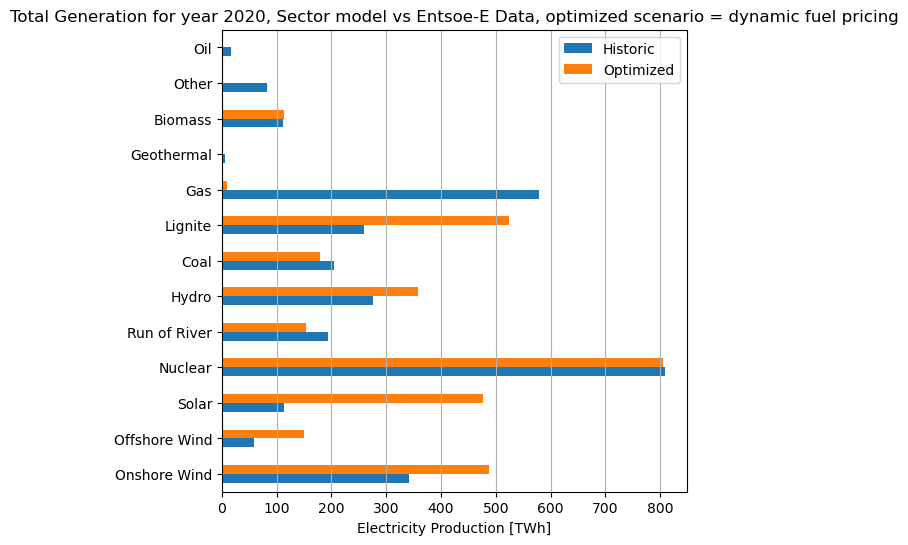

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(dynamic_fuel_pricing)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector model vs Entsoe-E Data, optimized scenario = dynamic fuel pricing')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()                                



In [ ]:
comparison_dataframe = pd.DataFrame([pd.Series(electric_supply_from_the_sector_models(base_2020)), pd.Series(electric_supply_from_the_sector_models(dynamic_fuel_pricing))]).T
comparison_dataframe['same?'] = comparison_dataframe[0].apply(lambda x: f"{x:.2e}") == comparison_dataframe[1].apply(lambda x: f"{x:.2e}")
comparison_dataframe
## TO see the comparison between all sources on an order of magnitude level 

,0,1,same?
offwind-ac,1.516537e+08,1.507745e+08,False
offwind-dc,4.545676e+01,7.134486e+01,False
offwind-float,2.983082e+01,4.980292e+01,False
onwind,4.860759e+08,4.869705e+08,False
ror,1.543798e+08,1.543795e+08,True
solar,3.304066e+08,3.303999e+08,True
solar rooftop,8.315063e+06,8.315131e+06,True
solar-hsat,1.373167e+08,1.373162e+08,True
geothermal,8.584787e+05,8.584778e+05,True
nuclear,8.041827e+08,8.041828e+08,True


In [ ]:
dynamic_fuel_pricing_filepath_electric = '/Users/katherine.shaw/Desktop/pypsa-eur/BAU validation/dynamic_fuel_pricing/networks/base_s_39_elec_.nc'
dynamic_fuel_pricing_electric_solve = pypsa.Network(dynamic_fuel_pricing_filepath_electric)
dynamic_fuel_pricing_electric_solve 

INFO:pypsa.io:Imported network base_s_39_elec_.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Unnamed PyPSA Network
---------------------
Components:
 - Bus: 117
 - Carrier: 26
 - Generator: 356
 - Line: 71
 - Link: 205
 - Load: 39
 - StorageUnit: 95
 - Store: 78
Snapshots: 8760

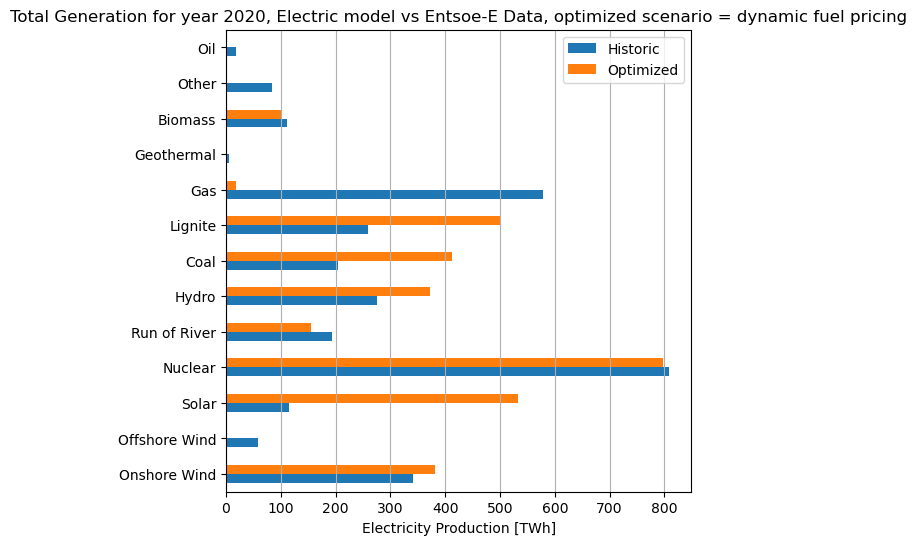

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), dynamic_fuel_pricing_electric_solve.statistics()['Supply'].loc[['Generator', 'StorageUnit']].drop(('StorageUnit', 'Battery Storage')).droplevel(0), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Electric model vs Entsoe-E Data, optimized scenario = dynamic fuel pricing')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()    

The gas-to-electricity link did not dispatch more to provide power in either the filtered sector solution or the electric solution. To different levels in both solutions, lignite and coal contributed much more than would be expected by historical data, and solar remains overbuilt.

## Gas in Conventional Carriers, also dynamic fuel pricing 

In this model gas was placed under a list of conventional_carriers under the configuration flag: existing_capacities. This did not noteably change gas/coal/lignite ratios

In [28]:
gas_conventional_carriers_with_dynamic_pricing_sector_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/BAU validation/no_carbon_price_but_gas_in_conventional_carriers/networks/base_s_39___2020.nc'
gas_conventional_carriers_with_dynamic_pricing_sector = pypsa.Network(gas_conventional_carriers_with_dynamic_pricing_sector_filepath)

gas_conventional_carriers_with_dynamic_pricing_sector_electric_solve_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/BAU validation/no_carbon_price_but_gas_in_conventional_carriers/networks/base_s_39_elec_.nc'
gas_conventional_carriers_with_dynamic_pricing_sector_electric_solve = pypsa.Network(gas_conventional_carriers_with_dynamic_pricing_sector_electric_solve_filepath)


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39_elec_.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


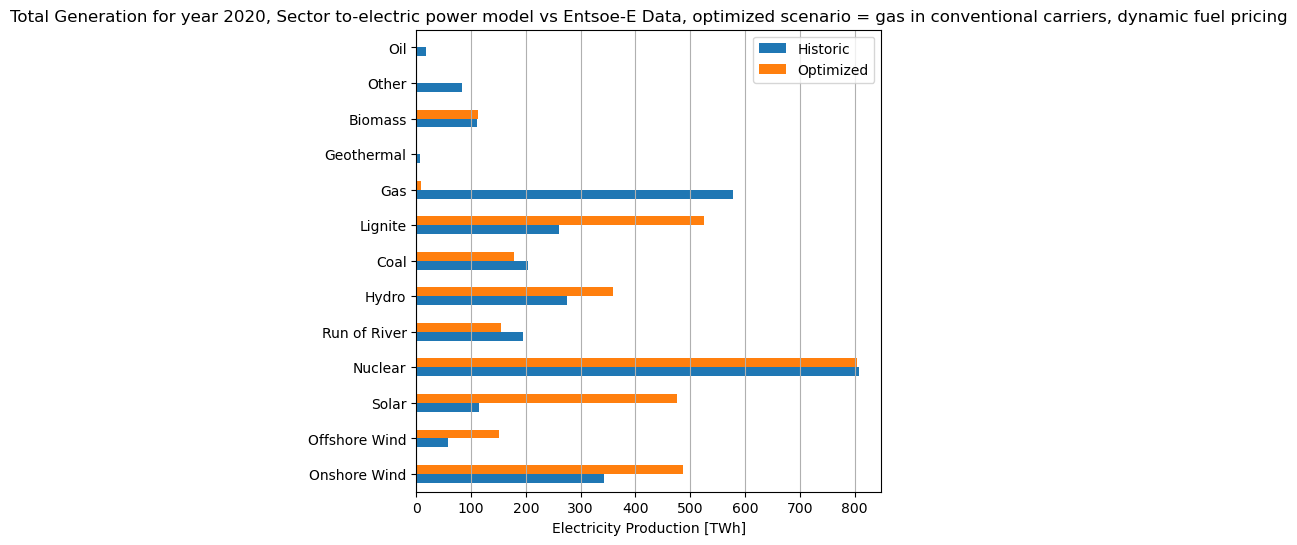

In [38]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(gas_conventional_carriers_with_dynamic_pricing_sector)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020, Sector to-electric power model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()                                


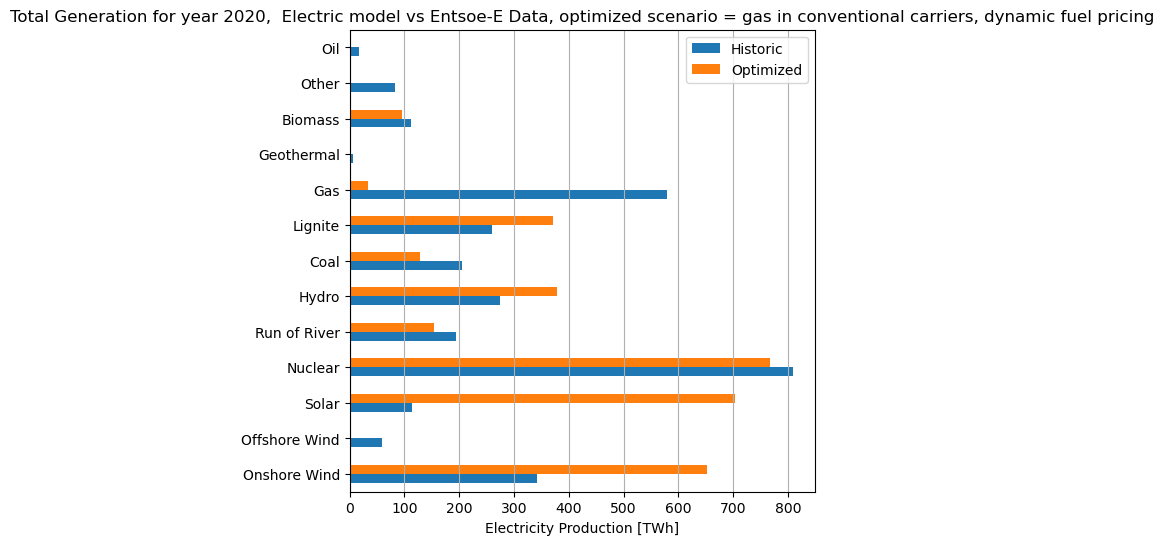

In [39]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), gas_conventional_carriers_with_dynamic_pricing_sector_electric_solve.statistics()['Supply'].loc[['Generator', 'StorageUnit']].drop(('StorageUnit', 'Battery Storage')).droplevel(0), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Electric model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()    

Overbuild of renewables and lignite, underbuild of gas not solved. Solar and Onshore wind now overbuilt to compensate.

## Carbon Pricing added : 15 EUR/ tCO2

In [ ]:
dynamic_fuel_gas_conventional_carbon_price_of_15_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/BAU validation/emission_price_15_and_gas_in_existing_capacities/networks/base_s_39___2020.nc'
dynamic_fuel_gas_conventional_carbon_price_of_15 = pypsa.Network(dynamic_fuel_gas_conventional_carbon_price_of_15_filepath)

dynamic_fuel_gas_conventional_carbon_price_of_15_electric_solve_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/BAU validation/emission_price_15_and_gas_in_existing_capacities/networks/base_s_39_elec_.nc'
dynamic_fuel_gas_conventional_carbon_price_of_15_electric_solve = pypsa.Network(dynamic_fuel_gas_conventional_carbon_price_of_15_electric_solve_filepath)


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39_elec_.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


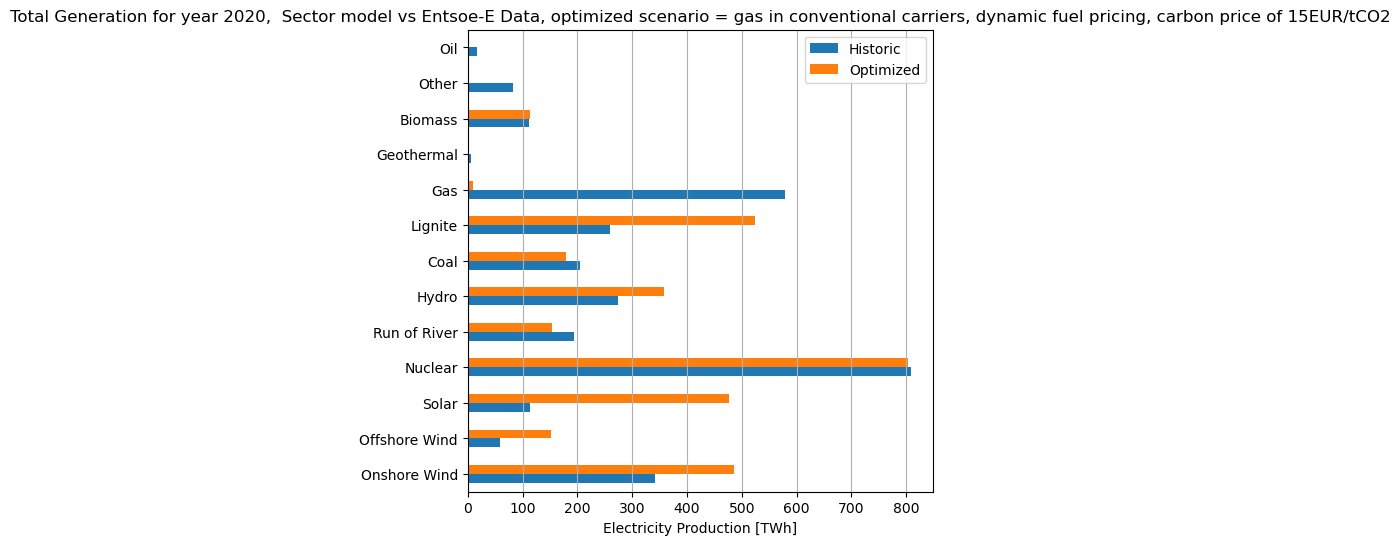

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(dynamic_fuel_gas_conventional_carbon_price_of_15)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, carbon price of 15EUR/tCO2')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()            

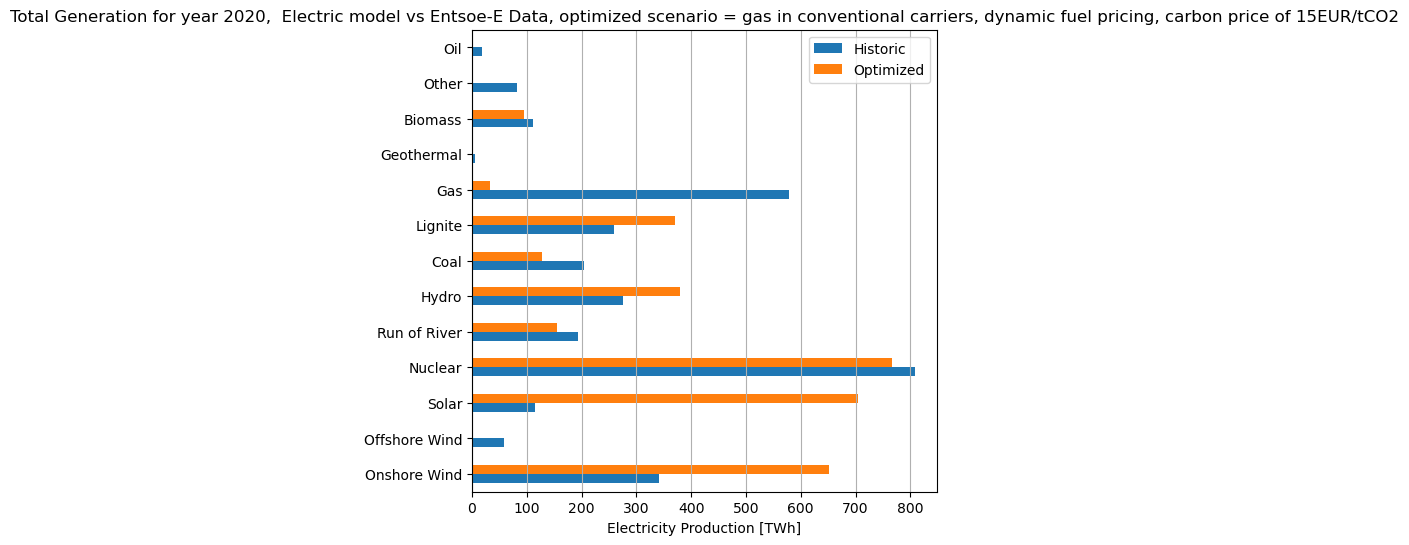

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), dynamic_fuel_gas_conventional_carbon_price_of_15_electric_solve.statistics()['Supply'].loc[['Generator', 'StorageUnit']].drop(('StorageUnit', 'Battery Storage')).droplevel(0), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Electric model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, carbon price of 15EUR/tCO2')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()    

Problem remains, gas underused. Use of lignite and coal down but resulting in an overuse of solar and wind compared to hisotircal data. 

In [ ]:
dynamic_fuel_gas_conventional_carbon_price_of_15.statistics().loc['Link'].head(40)
#Are the coal link and the generator links here different? 
dynamic_fuel_gas_conventional_carbon_price_of_15.statistics().loc['Generator'].head(40)


,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Energy Balance,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Offshore Wind (AC),3.236667e+04,3.236665e+04,1.512140e+08,0.00000,1.512140e+08,0.0,5.333226e-01,4.684770e+05,7.931364e+09,3.801846e+06,5.138308e+09,33.980370
Offshore Wind (DC),1.642000e-02,0.000000e+00,6.000217e+01,0.00000,6.000217e+01,0.0,4.171742e-01,1.861336e+01,4.432173e+03,1.504880e+00,2.098016e+03,34.963504
Offshore Wind (Floating),1.664000e-02,0.000000e+00,3.939419e+01,0.00000,3.939419e+01,0.0,2.704327e-01,1.833614e+01,4.502987e+03,9.892900e-01,1.369053e+03,34.728889
Onshore Wind,2.291842e+05,2.229871e+05,4.864788e+08,0.00000,4.864788e+08,0.0,2.423121e-01,8.113891e+06,2.925763e+10,1.215519e+07,1.556359e+10,31.992324
Run of River,4.834167e+04,4.834167e+04,1.543798e+08,0.00000,1.543798e+08,0.0,3.645564e-01,6.055760e+02,1.489747e+10,1.547350e+06,5.536146e+09,35.860564
Solar,2.764823e+05,2.764823e+05,3.304060e+08,0.00000,3.304060e+08,0.0,1.364195e-01,1.369282e+05,1.902748e+10,6.651405e+06,1.002572e+10,30.343638
biogas,1.085807e+04,1.085807e+04,2.916100e-01,0.00000,2.916100e-01,0.0,2.762921e-09,9.511672e+07,0.000000e+00,1.820953e+01,1.820958e+01,69.333333
coal,3.359515e+05,0.000000e+00,1.101624e+09,0.00000,1.101624e+09,0.0,3.743282e-01,1.841311e+09,0.000000e+00,1.053681e+10,1.053681e+10,9.564798
gas,1.584665e+06,1.584665e+06,3.134612e+09,0.00000,3.134612e+09,0.0,2.258096e-01,1.074705e+10,0.000000e+00,7.704291e+10,7.706894e+10,24.586433
geothermal,9.800009e+01,9.800000e+01,8.578923e+05,0.00000,8.578923e+05,0.0,9.993145e-01,5.884656e+02,3.176496e+08,1.552680e+06,3.518106e+07,41.008711


In [ ]:
dynamic_fuel_gas_conventional_carbon_price_of_15.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Combined-Cycle Gas            209394.23029        209394.21950   
            Offshore Wind (AC)                 0.04732             0.00000   
            Offshore Wind (DC)                 0.03880             0.00000   
            Offshore Wind (Floating)           0.03141             0.00000   
            Onshore Wind                  206086.79816             0.00000   
            Open-Cycle Gas                    23.31008            23.31000   
            Run of River                   48341.66702         48341.66702   
            Solar                              0.54460             0.00000   
            biomass                        12011.46289         12011.46098   
            coal                           92974.87088         92974.86606   
            geothermal                        98.00001            98.00000   
            lignite                        60675.93038         60675.92720   
            nuclear                       127614.10000        127614.10000   
            oil                             6025.02318          6025.02171   
            solar-hsat                    446256.04854             0.00000   
Line        AC                            363955.07379        336503.67241   
Link        DC                             67994.10924         27020.00000   
            H2 electrolysis                    0.03085             0.00000   
            H2 fuel cell                       0.03622             0.00000   
            battery charger                    0.46651             0.00000   
            battery discharger                 0.47613             0.00000   
Load        -                                  0.00000             0.00000   
StorageUnit Battery Storage                    0.25773             0.00000   
            Pumped Hydro Storage           55810.13555         55810.13555   
            Reservoir & Dam               104378.09356        104378.09356   
Store       Battery Storage                    0.90923             0.00000   
            Hydrogen Storage                  20.12009             0.00000   

                                            Supply    Withdrawal  \
Generator   Combined-Cycle Gas        3.252639e+07  0.000000e+00   
            Offshore Wind (AC)        1.567740e+02  0.000000e+00   
            Offshore Wind (DC)        1.623229e+02  0.000000e+00   
            Offshore Wind (Floating)  8.256171e+01  0.000000e+00   
            Onshore Wind              6.514362e+08  0.000000e+00   
            Open-Cycle Gas            3.232350e+00  0.000000e+00   
            Run of River              1.543598e+08  0.000000e+00   
            Solar                     5.401709e+02  0.000000e+00   
            biomass                   9.551392e+07  0.000000e+00   
            coal                      1.282755e+08  0.000000e+00   
            geothermal                7.835355e+05  0.000000e+00   
            lignite                   3.709206e+08  0.000000e+00   
            nuclear                   7.665763e+08  0.000000e+00   
            oil                       5.841420e+00  0.000000e+00   
            solar-hsat                7.037482e+08  0.000000e+00   
Line        AC                        9.131817e+08  9.196884e+08   
Link        DC                        5.022152e+08  5.022152e+08   
            H2 electrolysis           7.007356e+01  1.127128e+02   
            H2 fuel cell              3.506195e+01  7.012389e+01   
            battery charger           1.579396e+03  1.611964e+03   
            battery discharger        1.547488e+03  1.579398e+03   
Load        -                         0.000000e+00  3.186759e+09   
StorageUnit Battery Storage           3.677323e+02  4.087801e+02   
            Pumped Hydro Storage      6.724488e+07  8.965992e+07   
            Reservoir & Dam           3.115391e+08  0.000000e+00   
Store       Battery Storage           3.729320e+02  3.729296e+02   
            Hydro

### With 80 nodes (increase in spatial granularity)

The thinking here being, if there was a more granular understanding of renewables placement and possible congestion issues, would gas be used? 

In [ ]:
eighty_node_sector_network = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_80___2020.nc')

INFO:pypsa.io:Imported network base_s_80___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


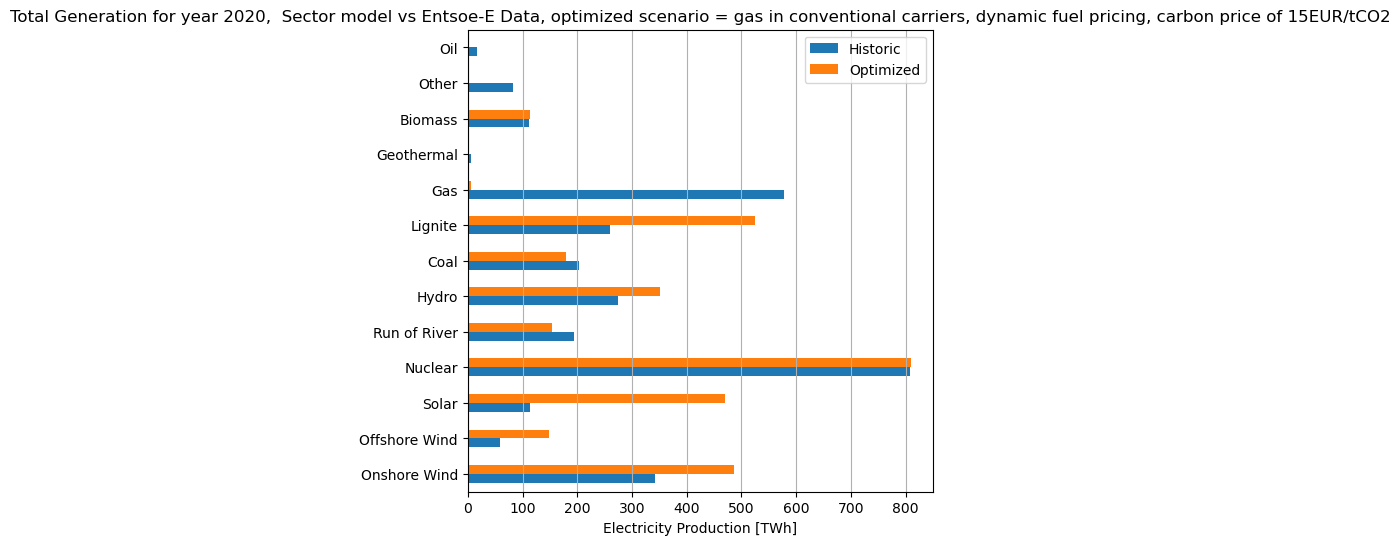

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(eighty_node_sector_network)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, carbon price of 15EUR/tCO2')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

No increase in gas usage or reduction of renewable expansion. 

Looked into the costs files as well, to see if there was a huge discrepancy in the costs between gas, coal, and lignite that would be causing the difference: 

lignite = {
    investment: 3827.1629, #EUR/kW_e
    FOM: 1.31, #%/year
    VOM: 3.2612, #EUR/MWh_e
}

coal = {
    investment: 3827.1629, #EUR/KW_e 
    FOM: 1.31, #%/year
    VOM: 3.2612 , #EUR/MWh_e
}

gas_CCGT = {
    investment: 931.235, #EUR/kW
    FOM: 3.3295, #%/year
    VOM: 4.6562, #EUR/MWh
}


## With conventional carriers NOT in extendable carriers 

extendable carriers in the electricity: section of the configuratio file

In [ ]:
# Electric networks 
test_file_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39_elec_.nc'
test_file = pypsa.Network(test_file_filepath)

INFO:pypsa.io:Imported network base_s_39_elec_.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


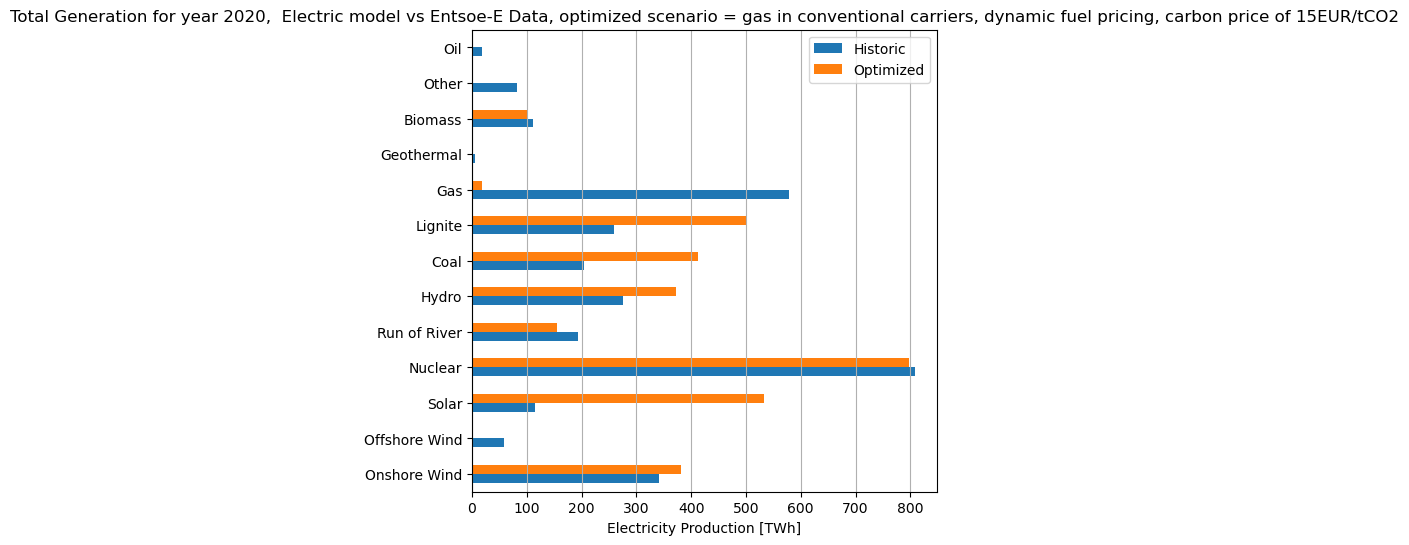

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), test_file.statistics()['Supply'].loc[['Generator', 'StorageUnit']].drop(('StorageUnit', 'Battery Storage')).droplevel(0), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Electric model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, carbon price of 15EUR/tCO2')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show()   

In [ ]:
test_file.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Combined-Cycle Gas            209394.22729        209394.21950   
            Offshore Wind (AC)                 0.02597             0.00000   
            Offshore Wind (DC)                 0.01930             0.00000   
            Offshore Wind (Floating)           0.01913             0.00000   
            Onshore Wind                  113941.25910             0.00000   
            Open-Cycle Gas                    23.31036            23.31000   
            Run of River                   48341.66702         48341.66702   
            Solar                              0.39769             0.00000   
            biomass                        12011.46098         12011.46098   
            coal                           92974.86606         92974.86606   
            geothermal                        98.00000            98.00000   
            lignite                        60675.92720         60675.92720   
            nuclear                       127614.10000        127614.10000   
            oil                             6025.02171          6025.02171   
            solar-hsat                    322816.42074             0.00000   
Line        AC                            344495.34548        336503.67241   
Link        DC                             39231.48826         27020.00000   
            H2 electrolysis                    0.02089             0.00000   
            H2 fuel cell                       0.02499             0.00000   
            battery charger                    0.30592             0.00000   
            battery discharger                 0.31223             0.00000   
Load        -                                  0.00000             0.00000   
StorageUnit Battery Storage                    0.14449             0.00000   
            Pumped Hydro Storage           55810.13555         55810.13555   
            Reservoir & Dam               104378.09356        104378.09356   
Store       Battery Storage                    0.45942             0.00000   
            Hydrogen Storage                  15.41166             0.00000   

                                            Supply    Withdrawal  \
Generator   Combined-Cycle Gas        1.802581e+07  0.000000e+00   
            Offshore Wind (AC)        8.004357e+01  0.000000e+00   
            Offshore Wind (DC)        7.492694e+01  0.000000e+00   
            Offshore Wind (Floating)  4.873200e+01  0.000000e+00   
            Onshore Wind              3.807829e+08  0.000000e+00   
            Open-Cycle Gas            1.989360e+00  0.000000e+00   
            Run of River              1.543777e+08  0.000000e+00   
            Solar                     4.241060e+02  0.000000e+00   
            biomass                   1.017339e+08  0.000000e+00   
            coal                      4.131675e+08  0.000000e+00   
            geothermal                8.584087e+05  0.000000e+00   
            lignite                   5.014076e+08  0.000000e+00   
            nuclear                   7.966671e+08  0.000000e+00   
            oil                       2.789450e+00  0.000000e+00   
            solar-hsat                5.322734e+08  0.000000e+00   
Line        AC                        8.917179e+08  8.955456e+08   
Link        DC                        2.952285e+08  2.952285e+08   
            H2 electrolysis           5.004324e+01  8.049419e+01   
            H2 fuel cell              2.502230e+01  5.004460e+01   
            battery charger           1.066171e+03  1.088156e+03   
            battery discharger        1.044630e+03  1.066171e+03   
Load        -                         0.000000e+00  3.186759e+09   
StorageUnit Battery Storage           1.571021e+02  1.807681e+02   
            Pumped Hydro Storage      6.074330e+07  8.099110e+07   
            Reservoir & Dam           3.115391e+08  0.000000e+00   
Store       Battery Storage           1.674195e+02  1.674195e+02   
            Hydro

In [ ]:
test_file2_filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc'
test_file_sector = pypsa.Network(test_file2_filepath)
test_file_sector

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Unnamed PyPSA Network
---------------------
Components:
 - Bus: 859
 - Carrier: 111
 - Generator: 953
 - GlobalConstraint: 2
 - Line: 71
 - Link: 3824
 - Load: 621
 - StorageUnit: 56
 - Store: 351
Snapshots: 1460

In [ ]:
test_file_sector.statistics()['Supply'].droplevel(0)

Offshore Wind (AC)                         1.515713e+08
Offshore Wind (DC)                         8.224539e+01
Offshore Wind (Floating)                   5.579427e+01
Onshore Wind                               4.861765e+08
Run of River                               1.543797e+08
                                               ...     
oil                                        5.682768e+02
residential rural water tanks              6.834130e+00
residential urban decentral water tanks    7.650170e+00
uranium                                    1.199800e-01
urban central water tanks                  1.445696e+07
Name: Supply, Length: 124, dtype: float64

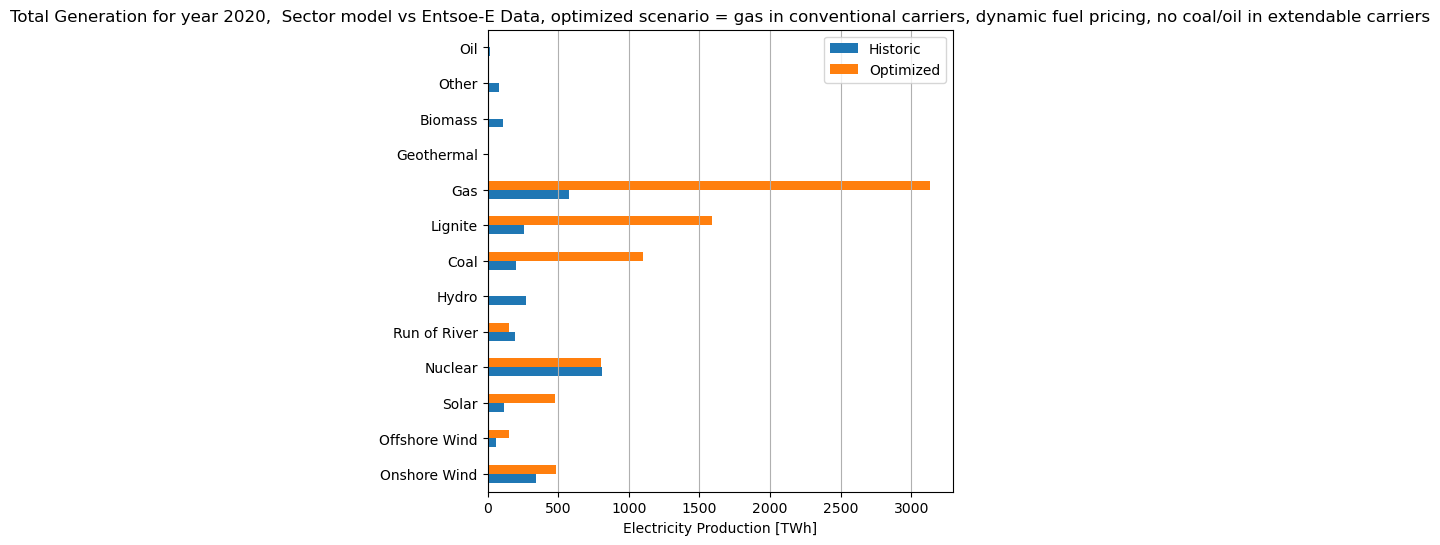

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), test_file_sector.statistics().loc['Generator']['Supply'], matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, no coal/oil in extendable carriers')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

## And here is one of the confusing elements about these tests: there is combined cycle gas turbine capacity that is larger than coal and lignite,  but its just not used in the power sector. 

<Axes: title={'center': 'Supply to the network by carrier type [MWh]'}>

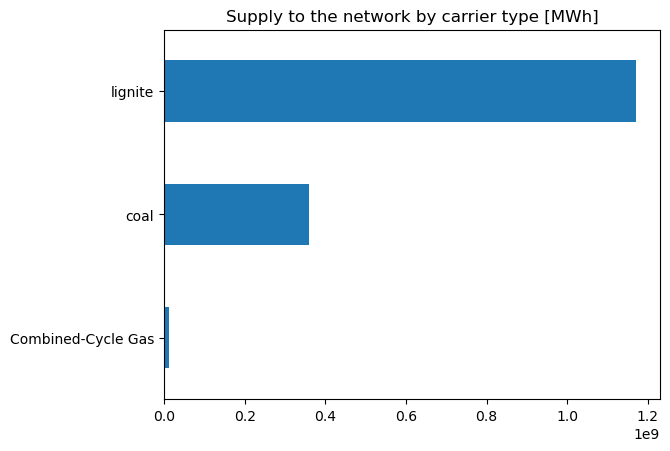

In [48]:
test_file_sector = gas_conventional_carriers_with_dynamic_pricing_sector
test_file_sector.statistics().loc['Link']['Supply'].loc[['Combined-Cycle Gas', 'coal', 'lignite']].plot(kind = 'barh', title =  'Supply to the network by carrier type [MWh]')


<Axes: title={'center': 'Capacity of the network by carrier type [MW]'}>

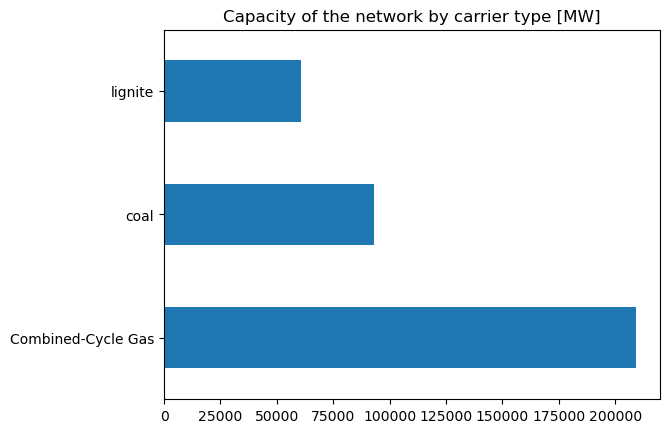

In [49]:
test_file_electric = gas_conventional_carriers_with_dynamic_pricing_sector_electric_solve
test_file_electric.statistics().loc['Generator']['Installed Capacity'].loc[['Combined-Cycle Gas', 'coal', 'lignite']].plot(kind = 'barh', title =  'Capacity of the network by carrier type [MW]')

In [50]:
electric_supply_from_the_sector_models(test_file_sector)

{'offwind-ac': 151317174.9744754,
 'offwind-dc': 73.92586055071173,
 'offwind-float': 51.9023432260585,
 'onwind': 486391376.0892732,
 'ror': 154379581.45823094,
 'solar': 330402501.00872934,
 'solar rooftop': 8316747.366379144,
 'solar-hsat': 137316961.94876677,
 'geothermal': 858477.5029795624,
 'nuclear': 804183100.0215065,
 'CCGT': 9464840.56664057,
 'OCGT': 81.57934505131415,
 'coal': 178603532.13479245,
 'lignite': 524692311.27295053,
 'oil': 10.798448773773316,
 'urban central CHP': 99.16590154640839,
 'urban central CHP CC': 60.89740727086614,
 'urban central solid biomass CHP': 113070555.97765976,
 'urban central solid biomass CHP CC': 24.342043994395958,
 'PHS': 46963138.984595515,
 'hydro': 311539646.8180219}

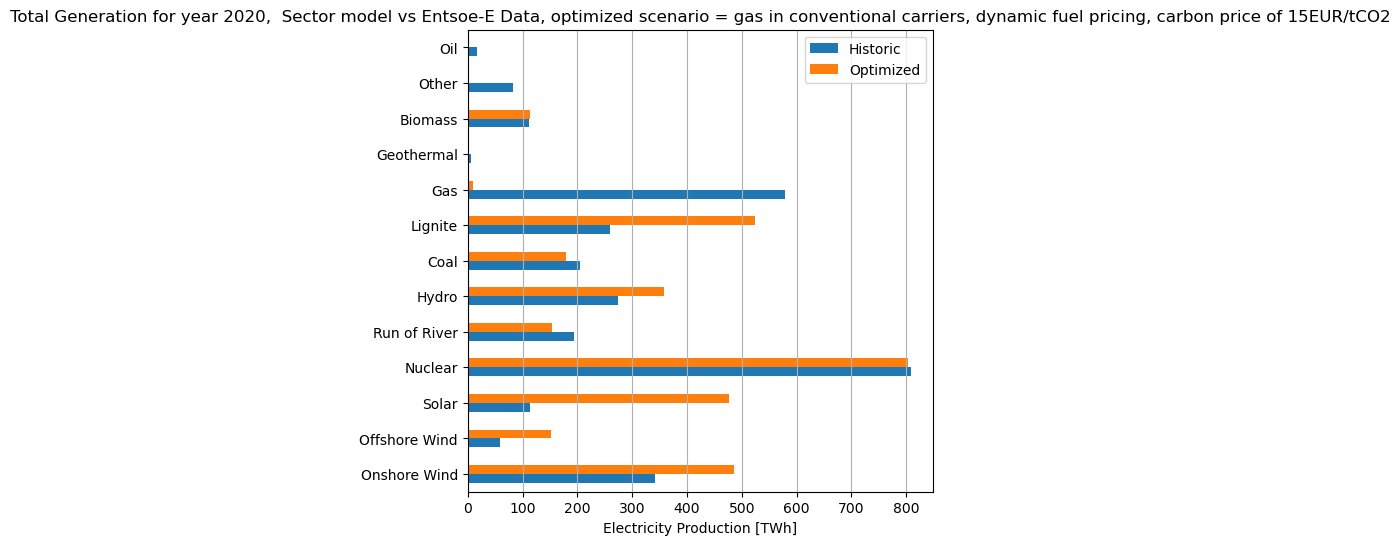

In [ ]:
import warnings
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(test_file2)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, carbon price of 15EUR/tCO2')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

In [ ]:
#why are the statistics of coal and lignite different between network.statistics.loc['Generator'] and network.statistics.loc['Links']
base_2020_electric_only_solve.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Combined-Cycle Gas            209394.24502        209394.21950   
            Offshore Wind (AC)                 0.01841             0.00000   
            Offshore Wind (DC)                 0.01264             0.00000   
            Offshore Wind (Floating)           0.01621             0.00000   
            Onshore Wind                   90488.33243             0.00000   
            Open-Cycle Gas                    23.31033            23.31000   
            Run of River                   48341.66702         48341.66702   
            Solar                              0.20982             0.00000   
            biomass                        12011.46347         12011.46098   
            coal                           92974.88409         92974.86606   
            geothermal                        98.00001            98.00000   
            lignite                        60675.93523         60675.92720   
            nuclear                       127614.10000        127614.10000   
            oil                             6025.02548          6025.02171   
            solar-hsat                    226570.09865             0.00000   
Line        AC                            343646.45545        336503.67241   
Link        DC                             38070.03479         27020.00000   
            H2 electrolysis                    0.02076             0.00000   
            H2 fuel cell                       0.02475             0.00000   
            battery charger                    0.29468             0.00000   
            battery discharger                 0.30075             0.00000   
Load        -                                  0.00000             0.00000   
StorageUnit Battery Storage                    0.13075             0.00000   
            Pumped Hydro Storage           55810.13555         55810.13555   
            Reservoir & Dam               104378.09356        104378.09356   
Store       Battery Storage                    0.38791             0.00000   
            Hydrogen Storage                  12.33495             0.00000   

                                            Supply    Withdrawal  \
Generator   Combined-Cycle Gas        3.060906e+07  0.000000e+00   
            Offshore Wind (AC)        5.181016e+01  0.000000e+00   
            Offshore Wind (DC)        4.525762e+01  0.000000e+00   
            Offshore Wind (Floating)  3.924408e+01  0.000000e+00   
            Onshore Wind              3.108058e+08  0.000000e+00   
            Open-Cycle Gas            2.293320e+00  0.000000e+00   
            Run of River              1.543773e+08  0.000000e+00   
            Solar                     2.241455e+02  0.000000e+00   
            biomass                   1.026802e+08  0.000000e+00   
            coal                      5.678178e+08  0.000000e+00   
            geothermal                8.584315e+05  0.000000e+00   
            lignite                   5.292454e+08  0.000000e+00   
            nuclear                   8.015903e+08  0.000000e+00   
            oil                       4.413090e+00  0.000000e+00   
            solar-hsat                3.959924e+08  0.000000e+00   
Line        AC                        8.493267e+08  8.529688e+08   
Link        DC                        2.890192e+08  2.890192e+08   
            H2 electrolysis           5.067864e+01  8.151623e+01   
            H2 fuel cell              2.534996e+01  5.069992e+01   
            battery charger           1.039017e+03  1.060443e+03   
            battery discharger        1.018026e+03  1.039018e+03   
Load        -                         0.000000e+00  3.186759e+09   
StorageUnit Battery Storage           1.034959e+02  1.250033e+02   
            Pumped Hydro Storage      4.534696e+07  6.046264e+07   
            Reservoir & Dam           3.115394e+08  0.000000e+00   
Store       Battery Storage           1.182197e+02  1.182187e+02   
            Hydro

## Wait, why is there so much lignite and coal in the sector model if it only goes to the electric buses? 

In [ ]:
test_file_sector.generators.carrier.unique()

array(['nuclear', 'geothermal', 'solar', 'offwind-ac', 'offwind-float',
       'solar-hsat', 'offwind-dc', 'onwind', 'ror', 'lignite', 'coal',
       'oil primary', 'gas', 'urban central heat vent',
       'urban central solar thermal', 'biogas', 'solid biomass',
       'unsustainable biogas', 'unsustainable solid biomass',
       'unsustainable bioliquids', 'solar rooftop', 'rural solar thermal',
       'urban decentral solar thermal'], dtype=object)

So there are lignite, coal, and gas in generators, but where are these generators connected to? 

In [ ]:
test_file_sector.generators[test_file_sector.generators.carrier.isin(['coal', 'lignite', 'gas'])]
#ok so these are gas "generators" going to the gas buses 
#also EU and lignite 'generators' going to the EU and lignite buses 

test_file_sector.links[test_file_sector.links.bus0 == 'EU lignite'].bus1.unique() #all the lignite carriers go into the electric buses 
test_file_sector.links[test_file_sector.links.bus0 == 'EU coal'].bus1.unique() #all the coal goes into the electric buses PLUS EU coal for industry 

test_file_sector.statistics().loc['Link']['Supply'].loc[['Combined-Cycle Gas', 'coal','lignite', 'Open-Cycle Gas']]

Combined-Cycle Gas    1.281572e+07
coal                  3.605882e+08
lignite               1.171654e+09
Open-Cycle Gas        1.264318e+02
Name: Supply, dtype: float64

In [ ]:
#is coal used for anything else? 
bus_connections(test_file_sector, 'EU coal')
#are there two ways for coal to leave?  -- there are links of different ages, operating at the same time and going to the same place 
test_file_sector.links[test_file_sector.links.bus0 == 'EU coal']

The generators connected to this bus are:    ['EU coal']
The stores connected to this bus are:   ['EU coal Store']
The outgoing links from this bus are to the bus:  ['AL0 0' 'AT0 0' 'BA0 0' 'BE0 0' 'BG0 0' 'CH0 0' 'CZ0 0' 'DE0 0' 'DK0 0'
 'DK1 0' 'EE0 0' 'ES0 0' 'ES6 0' 'FI1 0' 'FR0 0' 'FR5 0' 'GB2 0' 'GB3 0'
 'GR0 0' 'HR0 0' 'HU0 0' 'IE3 0' 'IT0 0' 'IT4 0' 'LT0 0' 'LU0 0' 'LV0 0'
 'ME0 0' 'MK0 0' 'NL0 0' 'NO1 0' 'PL0 0' 'PT0 0' 'RO0 0' 'RS0 0' 'SE1 0'
 'SI0 0' 'SK0 0' 'XK0 0' 'EU coal for industry' 'DE0 0' 'PL0 0' 'CZ0 0'
 'ES0 0' 'PL0 0' 'RO0 0' 'DE0 0' 'DK1 0' 'FI1 0' 'FR5 0' 'PL0 0' 'DE0 0'
 'ES0 0' 'FR0 0' 'HU0 0' 'IT0 0' 'IT4 0' 'PL0 0' 'SK0 0' 'CZ0 0' 'DE0 0'
 'GB2 0' 'IT0 0' 'PL0 0' 'RO0 0' 'SI0 0' 'SK0 0' 'CZ0 0' 'DE0 0' 'DK0 0'
 'DK1 0' 'ES0 0' 'FI1 0' 'GB2 0' 'NL0 0' 'PL0 0' 'DE0 0' 'DK0 0' 'DK1 0'
 'ES0 0' 'FI1 0' 'NL0 0' 'PL0 0' 'DE0 0' 'DK0 0' 'ES0 0' 'ES6 0' 'FI1 0'
 'FR0 0' 'GB3 0' 'IE3 0' 'IT4 0' 'PL0 0' 'PT0 0' 'AT0 0' 'DE0 0' 'ES0 0'
 'IT0 0' 'NL0 0' 'RO0 0' 'SE1 0' 

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,location,length_original,under_construction,dc,voltage,reversed,underwater_fraction,tags,geometry,project_status
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 coal-2020,EU coal,AL0 0,,coal,0.33,True,2020,40.000000,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
AT0 0 coal-2020,EU coal,AT0 0,,coal,0.33,True,2020,40.000000,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
BA0 0 coal-2020,EU coal,BA0 0,,coal,0.33,True,2020,40.000000,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
BE0 0 coal-2020,EU coal,BE0 0,,coal,0.33,True,2020,40.000000,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
BG0 0 coal-2020,EU coal,BG0 0,,coal,0.33,True,2020,40.000000,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL0 0 coal-2010,EU coal,PL0 0,,coal,0.33,True,2010,18.000000,178.799895,0.0,...,,NaN,NaN,NaN,NaN,False,NaN,,,
CZ0 0 coal-2015,EU coal,CZ0 0,,coal,0.33,True,2015,45.000000,409.090909,0.0,...,,NaN,NaN,NaN,NaN,False,NaN,,,
DE0 0 coal-2015,EU coal,DE0 0,,coal,0.33,True,2015,32.333333,9330.120850,0.0,...,,NaN,NaN,NaN,NaN,False,NaN,,,


In [ ]:
conventional_carriers = ['CCGT', 'OCGT', 'oil', "urban central solid biomass CHP", "urban central CHP", "urban central solid biomass CHP CC", "urban central CHP CC"] #biomass is technically low carbon, but CHP is given in links. biomass CHP only in urban central
conventional_links2 = test_file_sector.links[test_file_sector.links.carrier.isin(conventional_carriers)]
conventional_links2

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,location,length_original,under_construction,dc,voltage,reversed,underwater_fraction,tags,geometry,project_status
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 OCGT-2020,AL0 0 gas,AL0 0,,OCGT,0.4000,True,2020,25.00,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
AT0 0 OCGT-2020,AT0 0 gas,AT0 0,,OCGT,0.4000,True,2020,25.00,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
BA0 0 OCGT-2020,BA0 0 gas,BA0 0,,OCGT,0.4000,True,2020,25.00,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
BE0 0 OCGT-2020,BE0 0 gas,BE0 0,,OCGT,0.4000,True,2020,25.00,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
BG0 0 OCGT-2020,BG0 0 gas,BG0 0,,OCGT,0.4000,True,2020,25.00,0.000000,0.0,...,,0.0,NaN,NaN,NaN,False,NaN,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LT0 0 urban central solid biomass CHP-2025,EU solid biomass,LT0 0,,urban central solid biomass CHP,0.2689,True,2025,19.00,260.319821,0.0,...,,NaN,NaN,NaN,NaN,False,NaN,,,
RS0 0 urban central solid biomass CHP-2025,EU solid biomass,RS0 0,,urban central solid biomass CHP,0.2689,True,2025,19.00,111.565638,0.0,...,,NaN,NaN,NaN,NaN,False,NaN,,,
DE0 0 CCGT-2027,DE0 0 gas,DE0 0,,CCGT,0.5600,True,2027,40.25,61.857143,0.0,...,,NaN,NaN,NaN,NaN,False,NaN,,,


In [ ]:
#could it not be registering enough gas because also gas links go between each other and sometime gas is negative? 
# no, the links are restricted so that they only go to buses, see above
#because the carriers are all technologies that go from gas to electric 


In [ ]:
gas_buses = test_file_sector.buses[test_file_sector.buses.carrier == 'gas'].index
test_file_sector.links[test_file_sector.links.bus0.isin(gas_buses)].carrier.unique()
#no gas for cars? is that oil instead 
test_file_sector.links[test_file_sector.links.carrier == 'gas for industry']
bus_connections(test_file_sector, 'DE0 0 gas for industry')

The loads connected to this bus are:     ['DE0 0 gas for industry']
The incoming links to this bus are from the bus:  ['DE0 0 gas' 'DE0 0 gas']
The incoming links are:  Index(['DE0 0 gas for industry', 'DE0 0 gas for industry CC-2020'], dtype='object', name='Link')


## Pus gas in pypsa_eur buses, also put gas in conventional carriers 

In [ ]:
gas_in_pypsa_eur_buses = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc') #plus whatever changes were made above, dynamic fuel price == yes, carbon price == no, gas in existing_capacities: conventional_carriers

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


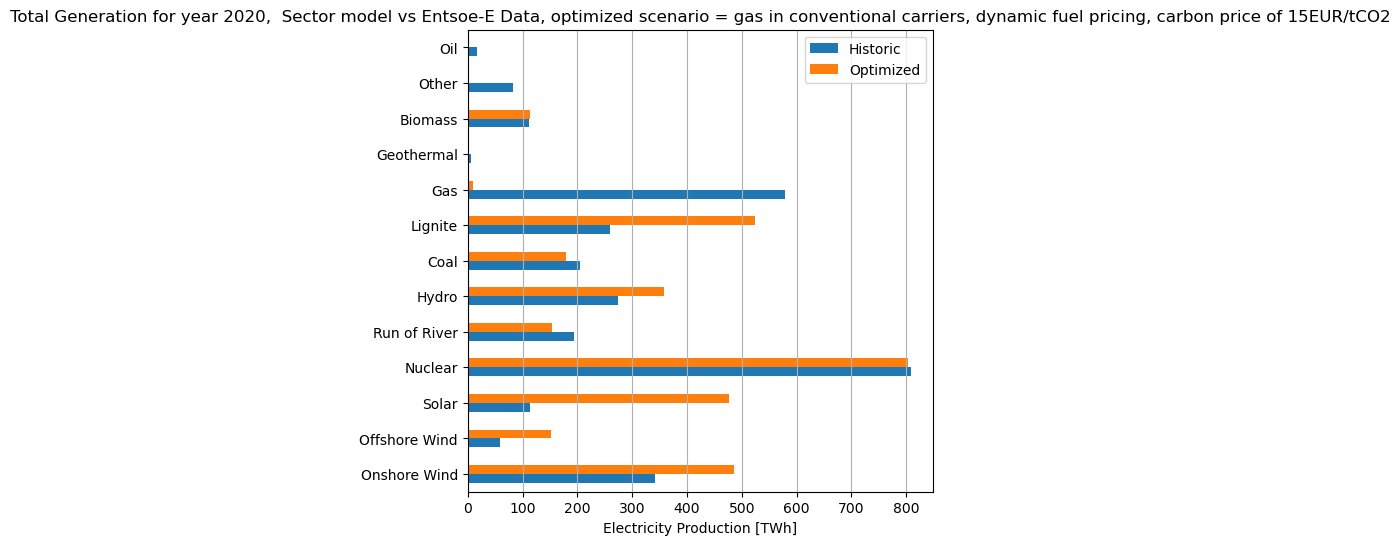

In [ ]:
# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(gas_in_pypsa_eur_buses)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, carbon price of 15EUR/tCO2')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

In [ ]:
gas_in_pypsa_eur_buses.statistics().loc['Link'].head(40)#.loc[['Combined-Cycle Gas', 'lignite', 'coal']]

,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Energy Balance,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Combined-Cycle Gas,373139.24782,372153.35983,1.281659e+07,1.690843e+07,-4.091839e+06,0.000000e+00,5.172830e-03,0.0,2.317662e+10,4.424559e+07,4.423798e+07,3.451619
DAC,0.00442,0.00000,3.166669e+01,9.341674e+01,-6.175005e+01,0.000000e+00,4.502262e-01,0.0,8.101340e+03,1.744600e-01,-9.260598e+02,-29.282548
DC,122948.15614,54040.00000,3.142230e+08,3.245477e+08,-1.032471e+07,3.245477e+08,3.013370e-01,0.0,3.238060e+09,3.183927e+06,2.293417e+09,7.298694
Fischer-Tropsch,0.04940,0.00000,2.638934e+02,3.827178e+02,-1.188244e+02,0.000000e+00,7.336032e-01,0.0,4.021311e+03,1.432900e+03,-5.980063e+02,-2.266600
H2 Electrolysis,0.01760,0.00000,4.303922e+01,6.796702e+01,-2.492780e+01,0.000000e+00,4.409091e-01,0.0,4.428672e+03,6.682400e-01,-5.361212e+02,-12.464358
H2 Fuel Cell,0.02520,0.00000,3.705060e+01,6.216288e+01,-2.511228e+01,0.000000e+00,2.817460e-01,0.0,3.334603e+03,6.270700e-01,-1.539634e+03,-41.550827
H2 pipeline,53.35896,0.00000,2.323916e+05,2.336765e+05,-1.284813e+03,2.323916e+05,4.971748e-01,0.0,2.811842e+05,2.489592e+03,2.615081e+05,1.125290
H2 pipeline retrofitted,3.67800,0.00000,3.023304e+04,3.023304e+04,0.000000e+00,2.977963e+04,9.383524e-01,0.0,3.229478e+04,3.145455e+02,3.866132e+04,1.278776
Open-Cycle Gas,58.40460,58.27500,9.278766e+01,1.551633e+02,-6.237565e+01,0.000000e+00,3.032295e-04,0.0,1.162486e+06,2.971098e+02,-1.827759e+03,-19.702550
SMR,13914.18490,0.00000,1.167687e+08,1.218880e+08,-5.119294e+06,0.000000e+00,9.999975e-01,0.0,9.488411e+08,1.228453e+06,9.500660e+08,8.136310


## With default pypsa EUR integration

pypsa_eur: under the configuration file is the key by which the electricity only section of pypsa is merged with the sector section of pypsa. In this area, conventional carriers typically require their own buses and then conventional generators (such as CCGT) become links

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


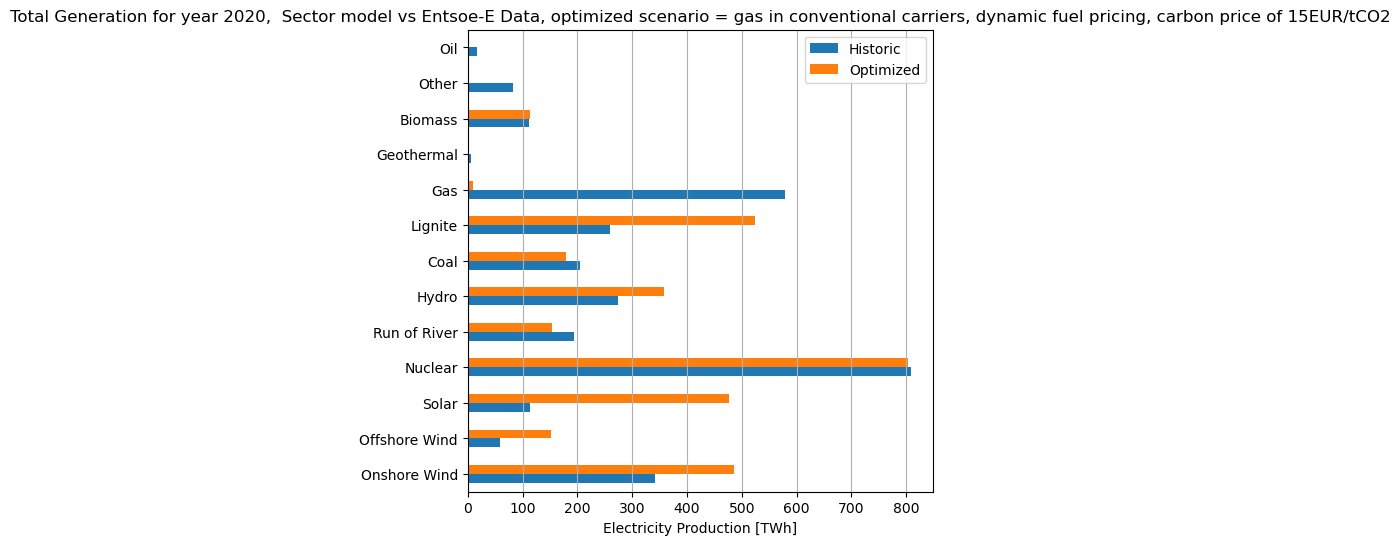

In [ ]:
default_pypsa_eur_integration = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')

# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(default_pypsa_eur_integration)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, carbon price of 15EUR/tCO2')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

In [ ]:
default_pypsa_eur_integration.statistics().loc['Link'].loc[['Combined-Cycle Gas', 'lignite', 'coal']]

,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Energy Balance,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Combined-Cycle Gas,373139.26342,372153.35983,1.299796e+07,1.714770e+07,-4.149743e+06,0.0,0.005246,0.0,2.317662e+10,4.486765e+07,4.485780e+07,3.451143
lignite,183866.50903,183866.44606,1.171577e+09,1.589873e+09,-4.182955e+08,0.0,0.987087,0.0,2.046042e+10,1.727271e+09,8.670395e+09,7.400618
coal,281742.07184,281742.01837,3.604987e+08,5.412081e+08,-1.807094e+08,0.0,0.219285,0.0,3.135188e+10,5.879038e+08,9.004076e+08,2.497672


In [ ]:
network = default_pypsa_eur_integration
coal_links = network.links[network.links.carrier == 'coal']
coal_links.index
(network.links_t.p1[coal_links.index] * -6).sum().sum()

178598689.2232347

In [ ]:
network = default_pypsa_eur_integration
coal_links = network.links[network.links.carrier == 'lignite']
coal_links.index
(network.links_t.p1[coal_links.index] * -6).sum().sum()

524657972.09286094

No change to the previous problems 

## Also putting section:conventional_generation into default

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


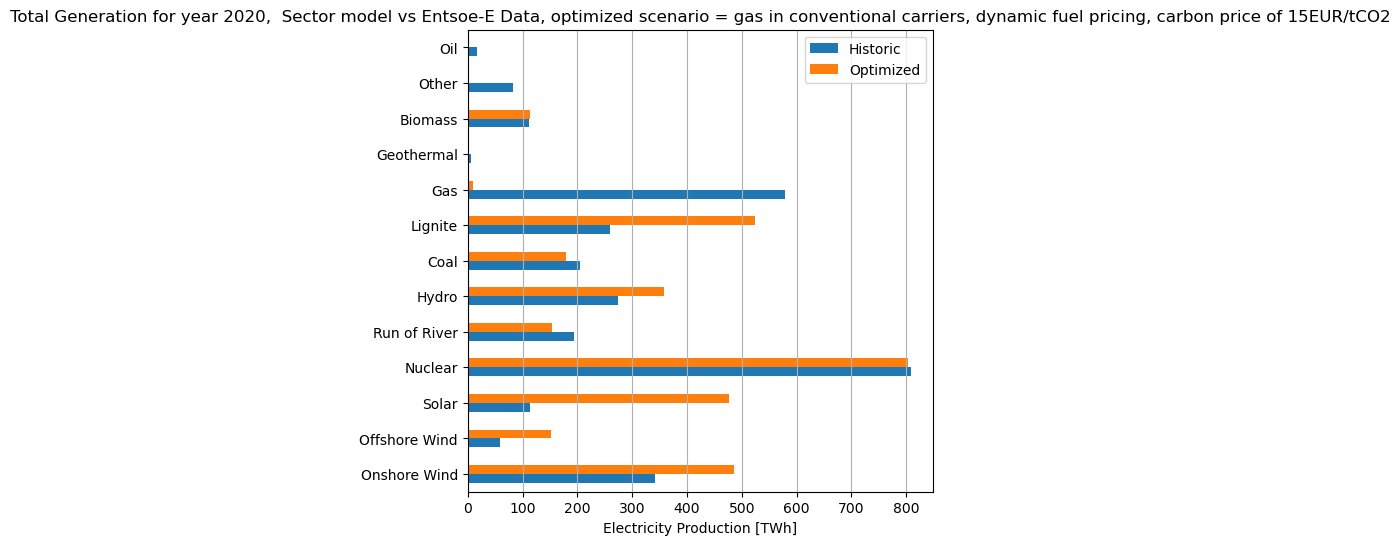

In [ ]:
default_pypsa_eur_integration2 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')

# Suppress all deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(default_pypsa_eur_integration2)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, optimized scenario = gas in conventional carriers, dynamic fuel pricing, carbon price of 15EUR/tCO2')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

In [ ]:
network = default_pypsa_eur_integration
coal_links = network.links[network.links.carrier == 'CCGT']
coal_links.index
(network.links_t.p1[coal_links.index] * -6).sum().sum()

9602712.21852153

In [ ]:
network = dynamic_fuel_gas_conventional_carbon_price_of_15

In [ ]:
network.links[network.links.carrier == 'CCGT'].marginal_cost

Link
AL0 0 CCGT-2020    2.618217
AT0 0 CCGT-2020    2.618009
BA0 0 CCGT-2020    2.618178
BE0 0 CCGT-2020    2.617412
BG0 0 CCGT-2020    2.617900
                     ...   
PL0 0 CCGT-2025    2.617659
RO0 0 CCGT-2025    2.617129
SI0 0 CCGT-2025    2.617723
DE0 0 CCGT-2027    2.617532
RO0 0 CCGT-2027    2.617343
Name: marginal_cost, Length: 218, dtype: float64

In [ ]:
network.links[network.links.carrier == 'coal'].marginal_cost

Link
AL0 0 coal-2020    1.086635
AT0 0 coal-2020    1.085943
BA0 0 coal-2020    1.085274
BE0 0 coal-2020    1.086364
BG0 0 coal-2020    1.086636
                     ...   
PL0 0 coal-2010    1.086869
CZ0 0 coal-2015    1.085922
DE0 0 coal-2015    1.085359
NL0 0 coal-2015    1.086044
PL0 0 coal-2022    1.086003
Name: marginal_cost, Length: 117, dtype: float64

In [ ]:
network.links[network.links.carrier == 'lignite'].marginal_cost

Link
AL0 0 lignite-2020    1.085567
AT0 0 lignite-2020    1.086556
BA0 0 lignite-2020    1.085353
BE0 0 lignite-2020    1.086365
BG0 0 lignite-2020    1.085329
                        ...   
BG0 0 lignite-2015    1.086182
DE0 0 lignite-2015    1.085633
BA0 0 lignite-2019    1.087083
PL0 0 lignite-2019    1.086248
GR0 0 lignite-2025    1.086845
Name: marginal_cost, Length: 104, dtype: float64

## Also ran this cleaned with a snakemake workflow -- no success in changing the previous problems 

### The next plant was to try to run the pypsa-eur default scenario to see if the lack of gas generators happened there, but unfortunately it took too long. 

# The Next Option: Forced operational Constraint 

Checking the Base Model before the constraint: 

In [7]:
filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/BAU validation/BAU_base_for_operational_constraint/networks/base_s_39___2020.nc'
base_operational_network = pypsa.Network(filepath)

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


/Users/katherine.shaw/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x37268b110>,
 <matplotlib.collections.LineCollection at 0x31a570500>)

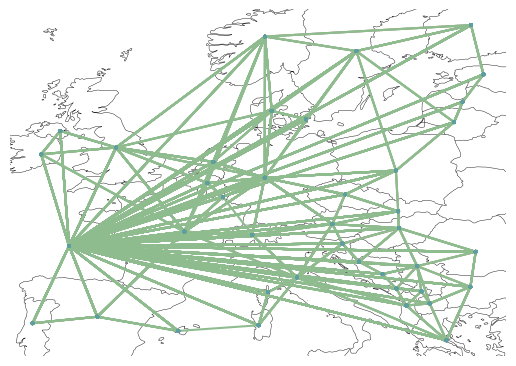

In [8]:
base_operational_network.plot()

In [11]:
base_operational_network.statistics()

Optimal Capacity  \
Generator Offshore Wind (AC)                            32366.66362   
          Offshore Wind (DC)                                0.01373   
          Offshore Wind (Floating)                          0.01576   
          Onshore Wind                                 229187.81847   
          Run of River                                  48341.66702   
...                                                             ...   
Store     oil                                              43.75547   
          residential rural water tanks                     0.18976   
          residential urban decentral water tanks           0.18863   
          uranium                                           0.81641   
          urban central water tanks                    206163.46934   

                                                   Installed Capacity  \
Generator Offshore Wind (AC)                              32366.64900   
          Offshore Wind (DC)                                  0.00000   
          Offshore Wind (Floating)                            0.00000   
          Onshore Wind                                   222987.08000   
          Run of River                                    48341.66702   
...                                                               ...   
Store     oil                                                 0.00000   
          residential rural water tanks                       0.00000   
          residential urban decentral water tanks             0.00000   
          uranium                                             0.00000   
          urban central water tanks                           0.00000   

                                                         Supply    Withdrawal  \
Generator Offshore Wind (AC)                       1.509835e+08  0.000000e+00   
          Offshore Wind (DC)                       4.627431e+01  0.000000e+00   
          Offshore Wind (Floating)                 3.588489e+01  0.000000e+00   
          Onshore Wind                             4.867242e+08  0.000000e+00   
          Run of River                             1.543797e+08  0.000000e+00   
...                                                         ...           ...   
Store     oil                                      2.471786e+01  2.471786e+01   
          residential rural water tanks            4.857100e+00  1.535036e+01   
          residential urban decentral water tanks  5.479700e+00  1.594757e+01   
          uranium                                  8.849000e-02  8.849000e-02   
          urban central water tanks                1.454669e+07  1.462862e+07   

                                                   Energy Balance  \
Generator Offshore Wind (AC)                         1.509835e+08   
          Offshore Wind (DC)                         4.627431e+01   
          Offshore Wind (Floating)                   3.588489e+01   
          Onshore Wind                               4.867242e+08   
          Run of River                               1.543797e+08   
...                                                           ...   
Store     oil                                        0.000000e+00   
          residential rural water tanks             -1.049326e+01   
          residential urban decentral water tanks   -1.046786e+01   
          uranium                                    0.000000e+00   
          urban central water tanks                 -8.193479e+04   

                                                   Transmission  \
Generator Offshore Wind (AC)                                0.0   
          Offshore Wind (DC)                                0.0   
          Offshore Wind (Floating)                          0.0   
          Onshore Wind                                      0.0   
          Run of River                                      0.0   
...                                                         ...   
Store     oil                                     

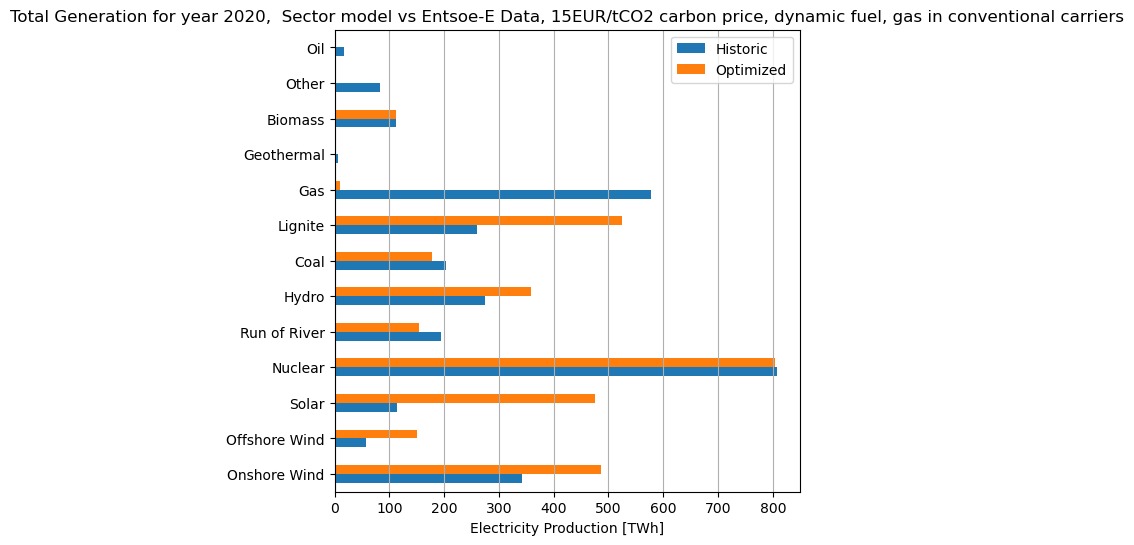

In [15]:
# Suppress all deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(base_operational_network)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, 15EUR/tCO2 carbon price, dynamic fuel, gas in conventional carriers')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 

relatively simillar to above. Onshore wind representation might actually be appropriate for 2024 

In [16]:
base_operational_network.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
CO2Limit,co2_atmosphere,NaN,co2_emissions,<=,3.314820e+09,-7.651565
co2_sequestration_limit,operational_limit,NaN,co2 sequestered,>=,0.000000e+00,0.000000


In [22]:
#changing the configuration file and script
n =  base_operational_network.copy()
import linopy
m = n.optimize.create_model()

In [35]:
gas_links = n.links[n.links.carrier == 'CCGT'].index
gas_links

Index(['AL0 0 CCGT-2020', 'AT0 0 CCGT-2020', 'BA0 0 CCGT-2020',
       'BE0 0 CCGT-2020', 'BG0 0 CCGT-2020', 'CH0 0 CCGT-2020',
       'CZ0 0 CCGT-2020', 'DE0 0 CCGT-2020', 'DK0 0 CCGT-2020',
       'DK1 0 CCGT-2020',
       ...
       'GR0 0 CCGT-2025', 'HR0 0 CCGT-2025', 'IE3 0 CCGT-2025',
       'IT0 0 CCGT-2025', 'NL0 0 CCGT-2025', 'PL0 0 CCGT-2025',
       'RO0 0 CCGT-2025', 'SI0 0 CCGT-2025', 'DE0 0 CCGT-2027',
       'RO0 0 CCGT-2027'],
      dtype='object', name='Link', length=218)

In [39]:
m.variables

linopy.model.Variables
----------------------
 * Generator-p_nom (Generator-ext)
 * Line-s_nom (Line-ext)
 * Link-p_nom (Link-ext)
 * Store-e_nom (Store-ext)
 * Generator-p (snapshot, Generator)
 * Line-s (snapshot, Line)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * StorageUnit-p_dispatch (snapshot, StorageUnit)
 * StorageUnit-p_store (snapshot, StorageUnit)
 * StorageUnit-state_of_charge (snapshot, StorageUnit)
 * StorageUnit-spill (snapshot, StorageUnit)
 * Store-p (snapshot, Store)
 * objective_constant

In [62]:
m.variables['Link-p'].groupby(n.links.carrier.to_xarray()).sum().sum("snapshot").loc["CCGT"]

LinearExpression
----------------
+1 Link-p[2019-01-01 00:00:00, AL0 0 CCGT-2020] + 1 Link-p[2019-01-01 06:00:00, AL0 0 CCGT-2020] + 1 Link-p[2019-01-01 12:00:00, AL0 0 CCGT-2020] ... +1 Link-p[2019-12-31 06:00:00, RO0 0 CCGT-2027] + 1 Link-p[2019-12-31 12:00:00, RO0 0 CCGT-2027] + 1 Link-p[2019-12-31 18:00:00, RO0 0 CCGT-2027]

In [59]:
m.variables['Link-p'].loc[:, gas_links].sum()

LinearExpression
----------------
+1 Link-p[2019-01-01 00:00:00, AL0 0 CCGT-2020] + 1 Link-p[2019-01-01 00:00:00, AT0 0 CCGT-2020] + 1 Link-p[2019-01-01 00:00:00, BA0 0 CCGT-2020] ... +1 Link-p[2019-12-31 18:00:00, SI0 0 CCGT-2025] + 1 Link-p[2019-12-31 18:00:00, DE0 0 CCGT-2027] + 1 Link-p[2019-12-31 18:00:00, RO0 0 CCGT-2027]

## Now operation constraint has been placed on the model, under the custom configuation flag 'forced gas constraint: (bool)' 

In [71]:
#operational constraint working? 
operational_constraint_test2 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
operational_constraint_test2.statistics().loc['Link']


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Energy Balance,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Combined-Cycle Gas,373139.20599,372153.35983,3.032000e+08,4.000000e+08,-9.680000e+07,0.000000e+00,0.122373,0.0,2.317662e+10,1.046824e+09,-2.454905e+09,-8.096654
DAC,0.00057,0.00000,4.126540e+00,1.217331e+01,-8.046760e+00,0.000000e+00,0.456140,0.0,1.044266e+03,2.267000e-02,-9.012264e+01,-21.893617
DC,115741.26662,54040.00000,2.688934e+08,2.778230e+08,-8.929659e+06,2.778230e+08,0.274016,0.0,3.109313e+09,2.701879e+06,1.750217e+09,6.508964
Fischer-Tropsch,0.00521,0.00000,2.748241e+01,3.985715e+01,-1.237474e+01,0.000000e+00,0.723608,0.0,4.244758e+02,1.492333e+02,-7.899574e+01,-2.872611
H2 Electrolysis,0.00227,0.00000,5.749610e+00,9.089780e+00,-3.340170e+00,0.000000e+00,0.458150,0.0,5.718941e+02,9.063000e-02,-4.015057e+01,-6.939394
...,...,...,...,...,...,...,...,...,...,...,...,...
urban central solid biomass CHP,61332.80802,43593.08657,4.459207e+08,4.074568e+08,3.846390e+07,0.000000e+00,0.758376,0.0,7.073699e+09,1.988059e+09,6.268899e+09,14.058326
urban central solid biomass CHP CC,0.00249,0.00000,1.976087e+01,1.909016e+01,6.707100e-01,0.000000e+00,0.658635,0.0,7.922353e+02,7.003612e+01,3.487265e+02,17.615044
urban central water tanks charger,18558.34698,0.00000,7.729866e+06,8.588740e+06,-8.588740e+05,0.000000e+00,0.052831,0.0,0.000000e+00,8.288785e+04,8.262107e+04,0.010689
urban central water tanks discharger,24320.35208,0.00000,6.908505e+06,7.676116e+06,-7.676116e+05,0.000000e+00,0.036030,0.0,0.000000e+00,7.344110e+04,7.317931e+04,0.010593


In [72]:
number = 400000000
f"{number:.2e}"
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
CO2Limit,co2_atmosphere,NaN,co2_emissions,<=,3.314820e+09,-7.651565
co2_sequestration_limit,operational_limit,NaN,co2 sequestered,>=,0.000000e+00,0.000000


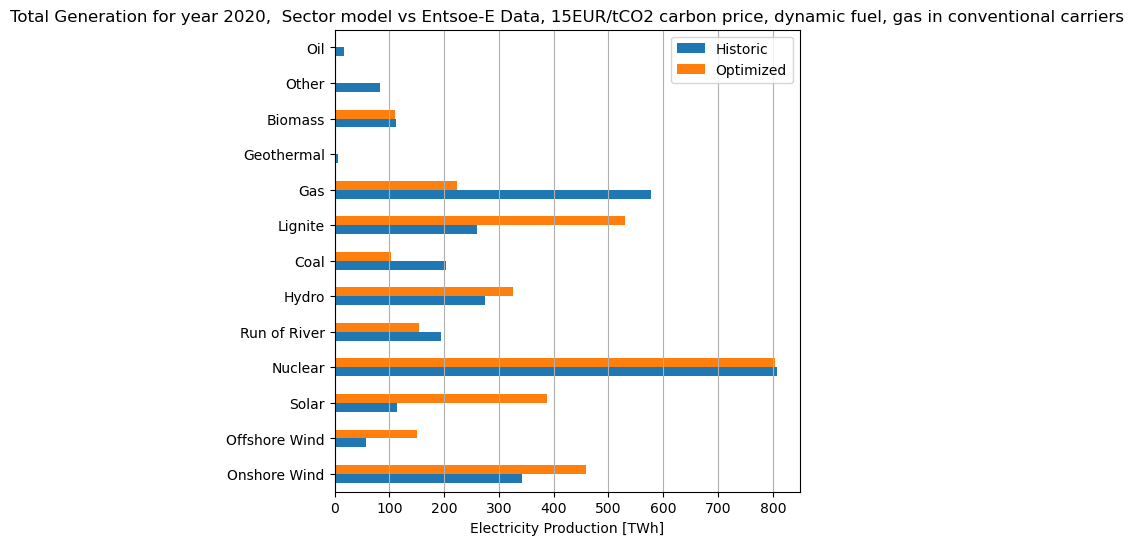

In [73]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = combine_series_by_dictionary(historic_entsoe_2020.T.groupby(level=1).sum().sum(axis=1), pd.Series(electric_supply_from_the_sector_models(operational_constraint_test2)), matched_data_dictionary2 )
fig, ax = plt.subplots(figsize=(6, 6))
df = df / 1e6  # TWh
df
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="x")
plt.title('Total Generation for year 2020,  Sector model vs Entsoe-E Data, 15EUR/tCO2 carbon price, dynamic fuel, gas in conventional carriers')
#fig.savefig(snakemake.output.production_bar, bbox_inches="tight")
plt.show() 